# 1. Imports

In [1]:
import pandas                 as pd
import numpy                  as np
import seaborn                as sns
import matplotlib.pyplot      as plt
import scikitplot             as skplt
import sklearn
import inflection

from sklearn.preprocessing    import MinMaxScaler, StandardScaler
from sklearn                  import model_selection
from sklearn.model_selection  import StratifiedKFold
from sklearn                  import ensemble
from sklearn                  import neighbors
from sklearn                  import linear_model
from sklearn.metrics          import roc_auc_score
from sklearn.ensemble         import RandomForestClassifier
from sklearn.naive_bayes      import GaussianNB
from xgboost                  import XGBClassifier
from lightgbm                 import LGBMClassifier
from catboost                 import CatBoostClassifier
from kds.metrics              import plot_cumulative_gain, plot_lift

from IPython.display          import Image
from IPython.core.display     import HTML

import warnings
warnings.filterwarnings("ignore")

## 1.1 Helper Functions

### 1.1.1 Models Performance

In [2]:
# definition of precision_at_k for the top 20.000 clients as default
def precision_at_k (data, k=2000):
    
    # reset index
    data = data.reset_index(drop=True)
    
    #create ranking order
    data['ranking'] = data.index + 1
    
    #calculate precision based on column named response
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k, 'precision_at_k']

# definition of recall_at_k for the top 20.000 clients as default
def recall_at_k (data, k=20000):
    
    # reset index
    data = data.reset_index(drop=True)
    
    #create ranking order
    data['ranking'] = data.index + 1
    
    #calculate recall based on the sum of responses
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return data.loc[k, 'recall_at_k']

##Define models accuracy function
def accuracy (model, x_val, y_val, yhat):
    
    data = x_val.copy()
    data['response'] = y_val.copy()
    data['score'] = yhat[:, 1].tolist()
    data = data.sort_values('score', ascending=False)
   
    precision = precision_at_k(data)      
    recall = recall_at_k(data)
    f1_score = round(2*(precision * recall) / (precision + recall), 3)
    roc = roc_auc_score(y_val, yhat[:,1])
    
    return pd.DataFrame({'Model Name': type(model).__name__,
                         'ROC AUC': roc.round(4),
                         'Precision@K Mean': np.mean(precision).round(4),
                         'Recall@K Mean': np.mean(recall).round(4),
                         'F1_Score' : np.mean(f1_score).round(4)}, index=[0])

## Define Cross-Validation
def cross_validation(model, x_train, y_train, k, data, Verbose = True):
    
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=28)
    precision_list = []
    recall_list = []
    f1_score_list = []
    roc_list = []
    i=1

    for train_cv, val_cv in kfold.split(x_train, y_train):
        
        if Verbose == True:
            
            print(f'Fold Number {i}/{k}')
            
        else:
            pass
        
        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]
        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold, y_train_fold.values.ravel())
        yhat = model.predict_proba(x_val_fold)        
        
        data = x_val_fold.copy()
        data['response'] = y_val_fold.copy()
        data['score'] = yhat[:, 1].tolist()
        data = data.sort_values('score', ascending=False)

        precision = precision_at_k(data) 
        precision_list.append(precision)
        
        recall = recall_at_k(data)
        recall_list.append(recall)
        
        f1_score = round(2*(precision * recall) / (precision + recall), 3)
        f1_score_list.append(f1_score)
       
        roc = roc_auc_score(y_val_fold, yhat[:, 1])
        roc_list.append(roc)
            
        
        i+=1
        
    df = pd.DataFrame({'Model Name': type(model).__name__,
                         'ROC AUC': roc.round(4),
                         'Precision@K Mean': np.mean(precision).round(4),
                         'Recall@K Mean': np.mean(recall).round(4),
                         'F1_Score' : np.mean(f1_score).round(4)}, index=[0])
    return df

### 1.1.2 Graphic

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

jupyter_settings();

Populating the interactive namespace from numpy and matplotlib


## 1.2 Loading Data 

In [92]:
df_raw = pd.read_csv('data/train.csv')

# 2. Data Details

In [93]:
df2 = df_raw.copy()

In [94]:
df2.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 2.1 Data Dictionary

|The data set that I am using is from Kaggle (https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction).



| Feature                                       |Description   
|:---------------------------|:---------------
| **Id**                         | Unique ID for the customer   | 
| **Gender**                           | Gender of the customer   | 
| **Age**                           | Age of the customer   | 
| **Driving License**                                   | 0, customer does not have DL; 1, customer already has DL  | 
| **Region Code**                               | Unique code for the region of the customer   | 
| **Previously Insured**                     | 1, customer already has vehicle insurance; 0, customer doesn't have vehicle insurance | 
| **Vehicle Age**                     | Age of the vehicle | 
| **Vehicle Damage**                                  | 1, customer got his/her vehicle damaged in the past; 0, customer didn't get his/her vehicle damaged in the past | 
| **Anual Premium**                             | The amount customer needs to pay as premium in the year | 
| **Policy sales channel**                                    | Anonymized Code for the channel of outreaching to the customer ie  | 
| **Vintage**                | Number of Days, customer has been associated with the company  | 
| **Response**              | 1, customer is interested; 0, customer is not interested. |    

## 2.2 Rename Columns

In [95]:
cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 
            'Policy_Sales_Channel', 'Vintage', 'Response']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df2.columns = cols_new

## 2.3 Data Dimensions

In [96]:
print ('Number of Rows: {}'.format( df2.shape[0]))
print ('Number of Columns: {}'.format( df2.shape[1]))

Number of Rows: 381109
Number of Columns: 12


## 2.4 Data Types

In [97]:
df2.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 2.5 Missing Values

In [98]:
df2.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 2.6 Change Types

In [99]:
# changing data types from float to int64

df2['region_code'] = df2['region_code'].astype('int64')     

df2['policy_sales_channel'] = df2['policy_sales_channel'].astype('int64')    

df2['annual_premium'] = df2['annual_premium'].astype('int64')    


## 2.7 Descriptive Statistics

In [100]:
# Split numerical and categorical features
num_attributes = df2.select_dtypes( include=['int64', 'float64'])
cat_attributes = df2.select_dtypes( exclude=['int64', 'float64'])

### 2.7.1 Numerical Attributes

In [101]:
#Central Tendency - mean, meadian
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concat
m= pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes','min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


**Age** of customers ranges from 20 to 85 years old, average being close to 38.

**Driving Licence** ≈ 100% of the clients in analysis retain a one

**Vehicle insurance** ≈ 55% of the clients do not hold one

**Annual Premium** Clients pay ≈ 30.5k on their current health insurance policy

**Response** 12.23% of the clients showed to be interest in purchasing a vehicle insurance.

### 2.7.2 Categorical Attributes

In [102]:
# add percentage of most common attribute
cat_attributes_p = cat_attributes.describe().T
cat_attributes_p['freq_p'] = cat_attributes_p['freq'] / cat_attributes_p['count']
cat_attributes_p

,count,unique,top,freq,freq_p
gender,381109,2,Male,206089,0.540761
vehicle_age,381109,3,1-2 Year,200316,0.525613
vehicle_damage,381109,2,Yes,192413,0.504877


**Gender** ≈ 54% of the customers are Male

**Vehicle Age** Customers age vehicle is most commonly between 1 and 2 years old

**Vehicle Damage** ≈ 50% of the customers got his/her vehicle damaged in the past

**TOP 3 Combos Categorical Attributes**

In [103]:
categorical_combo = pd.DataFrame(round(cat_attributes.value_counts(normalize=True) * 100)).reset_index().rename(columns={0: '%'})
categorical_combo['count'] = cat_attributes.value_counts().values
display(categorical_combo)

,gender,vehicle_age,vehicle_damage,%,count
0,Male,1-2 Year,Yes,21.0,79533
1,Female,< 1 Year,No,17.0,66047
2,Male,< 1 Year,No,13.0,50543
3,Female,1-2 Year,Yes,13.0,48692
4,Male,1-2 Year,No,11.0,42791
5,Female,1-2 Year,No,8.0,29300
6,Female,< 1 Year,Yes,7.0,25274
7,Male,< 1 Year,Yes,6.0,22922
8,Male,> 2 Years,Yes,3.0,10293
9,Female,> 2 Years,Yes,1.0,5699


**1.** Males with car age between 1-2 years old that got vehicle damaged in the past 

**2.** Female with car newer than 1 year old that never got vehicle damage in the past

**3.** Males with car newer than 1 year old that never got vehicle damage in the past

# 3 Feature Engineering

In [104]:
df3 = df2.copy()

## 3.1 Features Creation 

In [105]:
# vehicle age
df3['vehicle_age']= df3['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_years' if x== '1-2 Year' else 'under_1_year')
# vehicle damage
df3['vehicle_damage'] = df3['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

## 3.2 Mind Map

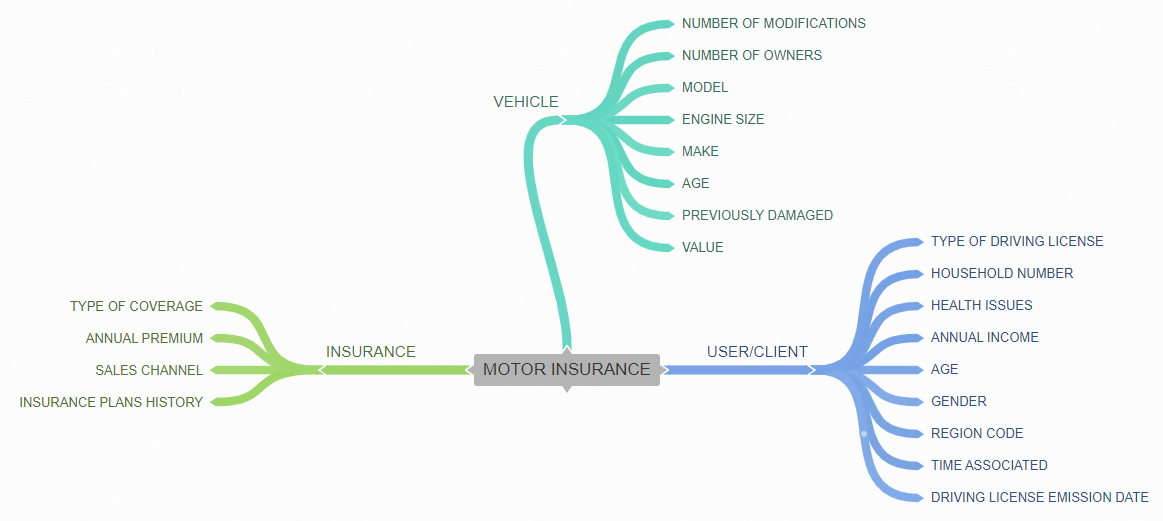

In [106]:
Image ('img/mindmap.png')

## 3.3 Hypothesis Formulation

### 3.3.1 User/Client

**1.** Interest is greater on older people (over 45)

**2.** Interest is greater on female

**3.** Interest is greater on customers holding a driving license

**4.** Interest is greater on customers with higher household numbers

**5.** Interest is greater on customers with higher annual income

**6.** Interest is greater on more time associated users (over 150 days)

### 3.3.2 Vehicle

**1.** Interest is greater with newer vehicles

**2.** Interest is greater with higher historical number of owners

**3.** Interest is greater with higher modification vehicles

**4.** Interest is greater with bigger engine size

**5.** Interest is greater with previously damaged vehicles

**6.** Interest is greater with higher value vehicles

### 3.3.3 Insurance

**1.** Interest is greater on previously insured owners

**2.** Interest is greater on phone driven sales

**3.** Interest is greater on higher annual premiums (over 30k/year)

## 3.4 Final List of Hypothesis
**This comprises the list of hypothesis that can be tested with currently available data**

**1.** Interest is greater on older people (over 45)

**2.** Interest is greater on female

**3.** Interest is greater on customers holding a driving license

**4.** Interest is greater on more time associated users (over 150 days)

**5.** Interest is greater with newer vehicles

**6.** Interest is greater with previously damaged vehicles

**7.** Interest is greater on previously insured owners

**8.** Interest is greater on higher annual premiums (over 30k/year)

# 4 Exploratory Data Analysis (EDA)

In [107]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.4.1 Response Variable

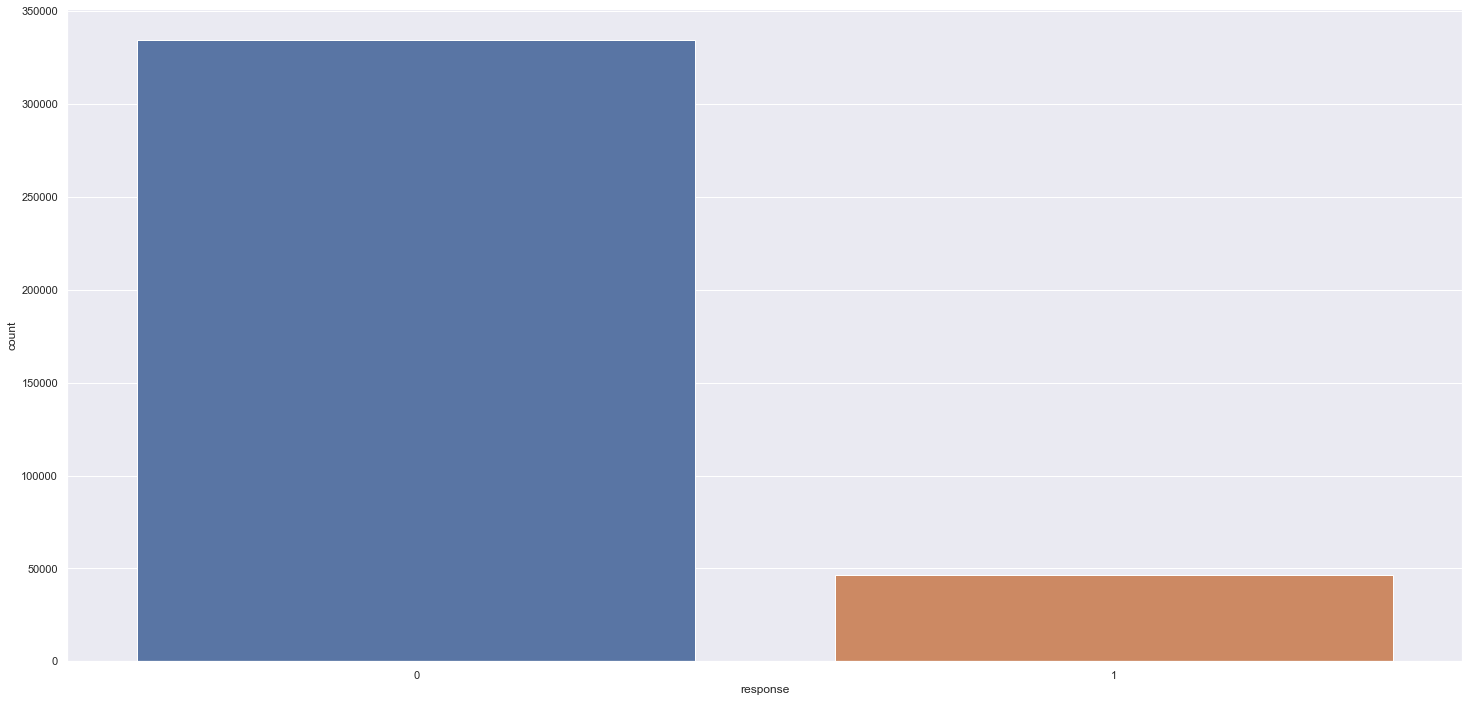

In [108]:
sns.countplot(x = 'response', data=df4);

### 4.1.2 Numerical Variables

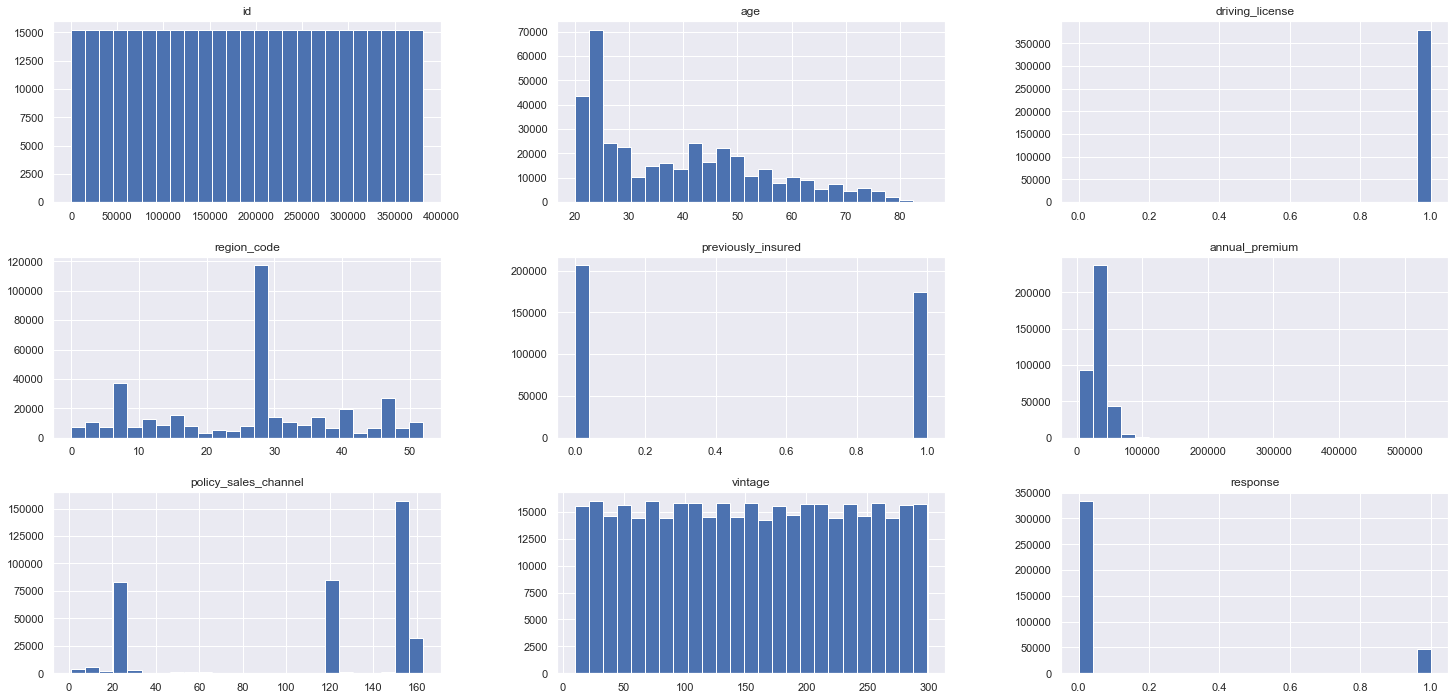

In [109]:
num_attributes.hist(bins=25);

#### 4.1.2.1 Age

**Findings** The average age of interested clients is higher than non-interested clients. Both plots disclose well how younger clients are not as interested as older clients.

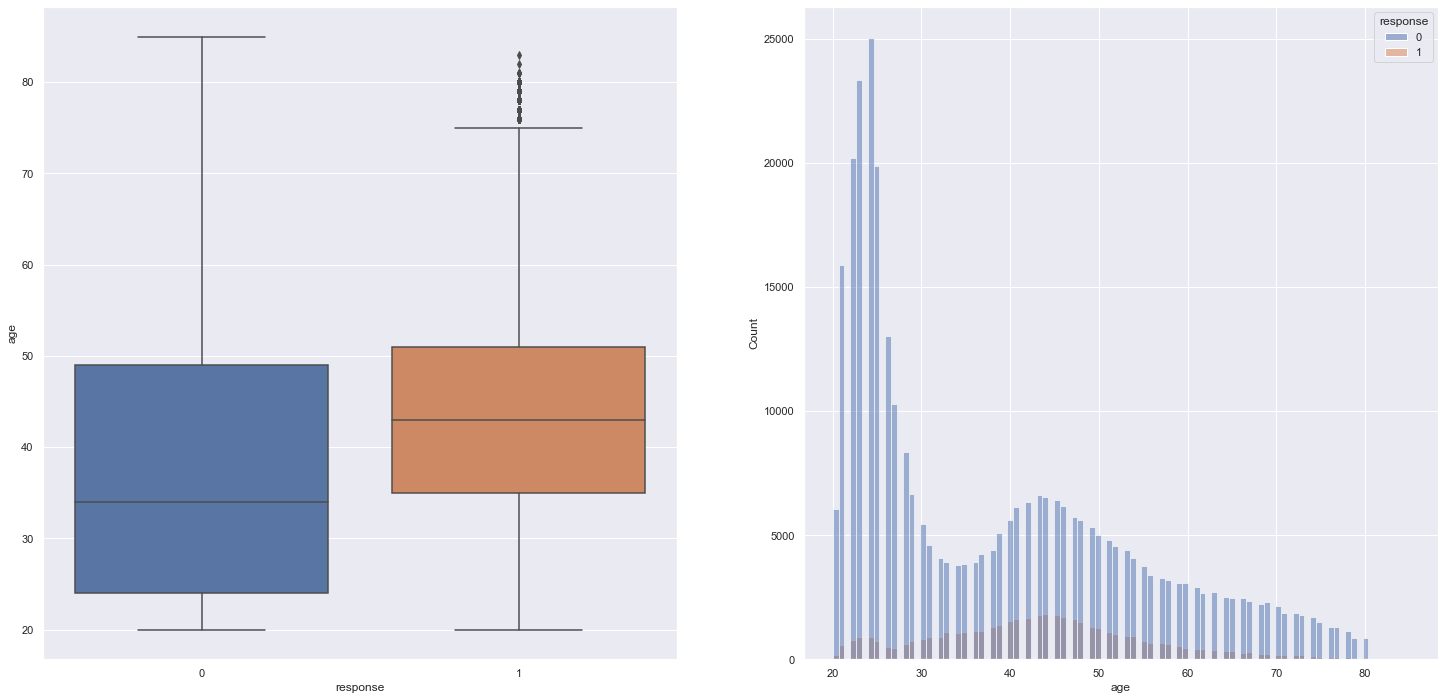

In [110]:
plt.subplot(1, 2, 1)
sns.boxplot( x='response', y='age', data=df4 )

plt.subplot(1, 2, 2)
sns.histplot(df4, x='age', hue='response');

#### 4.1.2.2 Driving Licence
**Findings** Only clients holding a driving license are part of the dataset. 12% are potential vehicle insurance customers

In [111]:
aux2 = pd.DataFrame(round(df4[['driving_license', 'response']].value_counts(normalize=True) * 100)).reset_index().rename(columns={0: '%'})
aux2['count'] = (aux2['%'] * df4.shape[0]).astype(int)
aux2

,driving_license,response,%,count
0,1,0,88.0,33537592
1,1,1,12.0,4573308
2,0,0,0.0,0
3,0,1,0.0,0


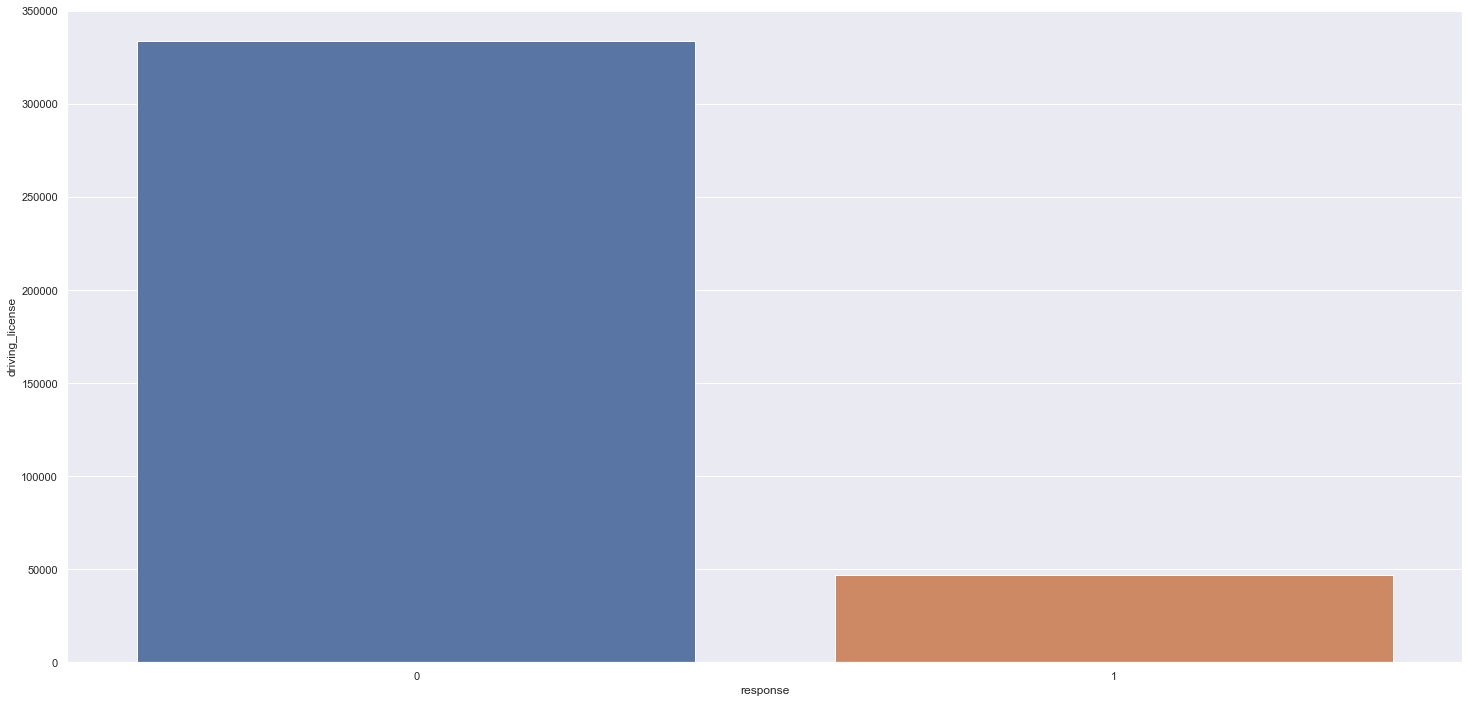

In [112]:
aux2 = df4[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='driving_license', data=aux2 );

#### 4.1.2.3 Region Code

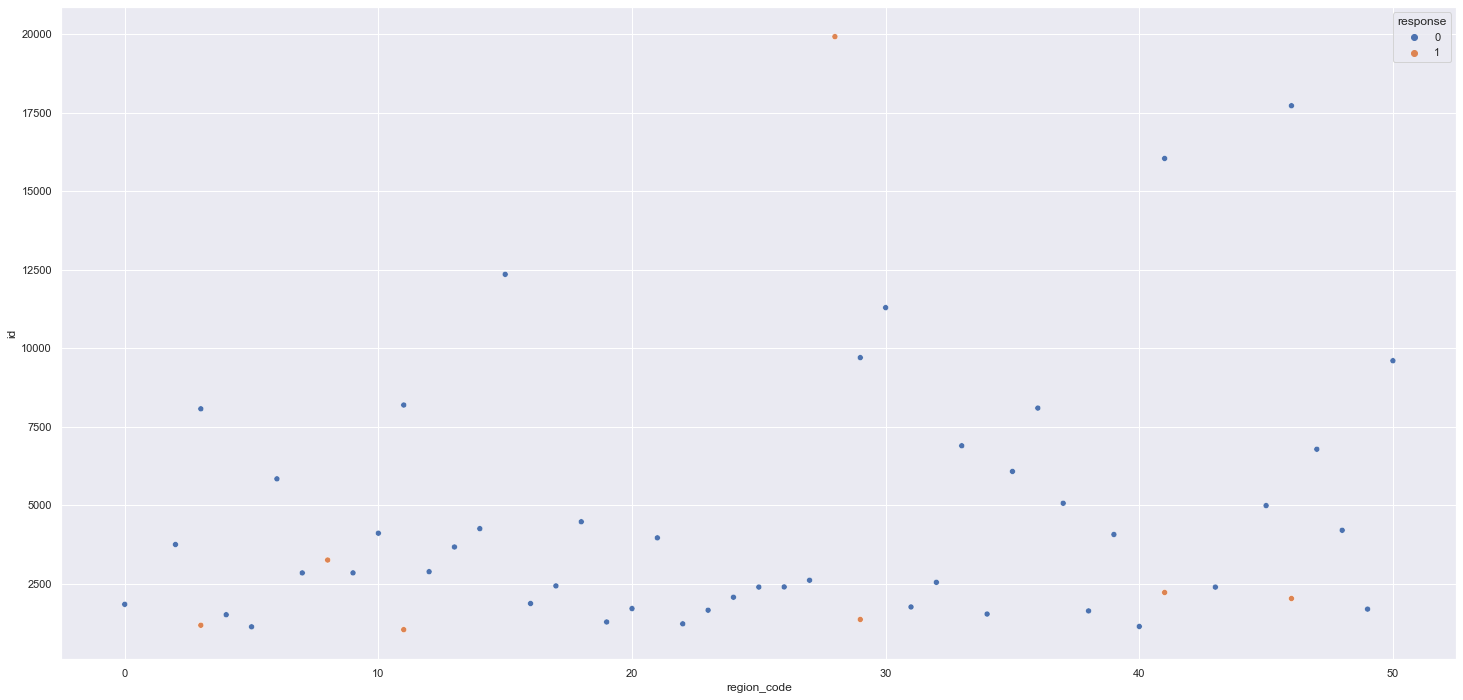

In [113]:
aux3 = df4[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index()
aux3 = aux3[(aux3['id'] > 1000) & (aux3['id'] < 20000)]
sns.scatterplot( x='region_code', y='id', hue='response', data=aux3 );

#### 4.1.2.4 Previously Insured
**Findings** All potential vehicle insurance customers have never held an insurance. 46% of our clients already have vehicle insurance and are not interested.

In [114]:
aux4 = pd.DataFrame(round(df4[['previously_insured', 'response']].value_counts(normalize=True) * 100)).reset_index().rename(columns={0: '%'})
aux4['count'] = (aux4['%'] * df4.shape[0]).astype(int)
aux4

,previously_insured,response,%,count
0,1,0,46.0,17531014
1,0,0,42.0,16006578
2,0,1,12.0,4573308
3,1,1,0.0,0


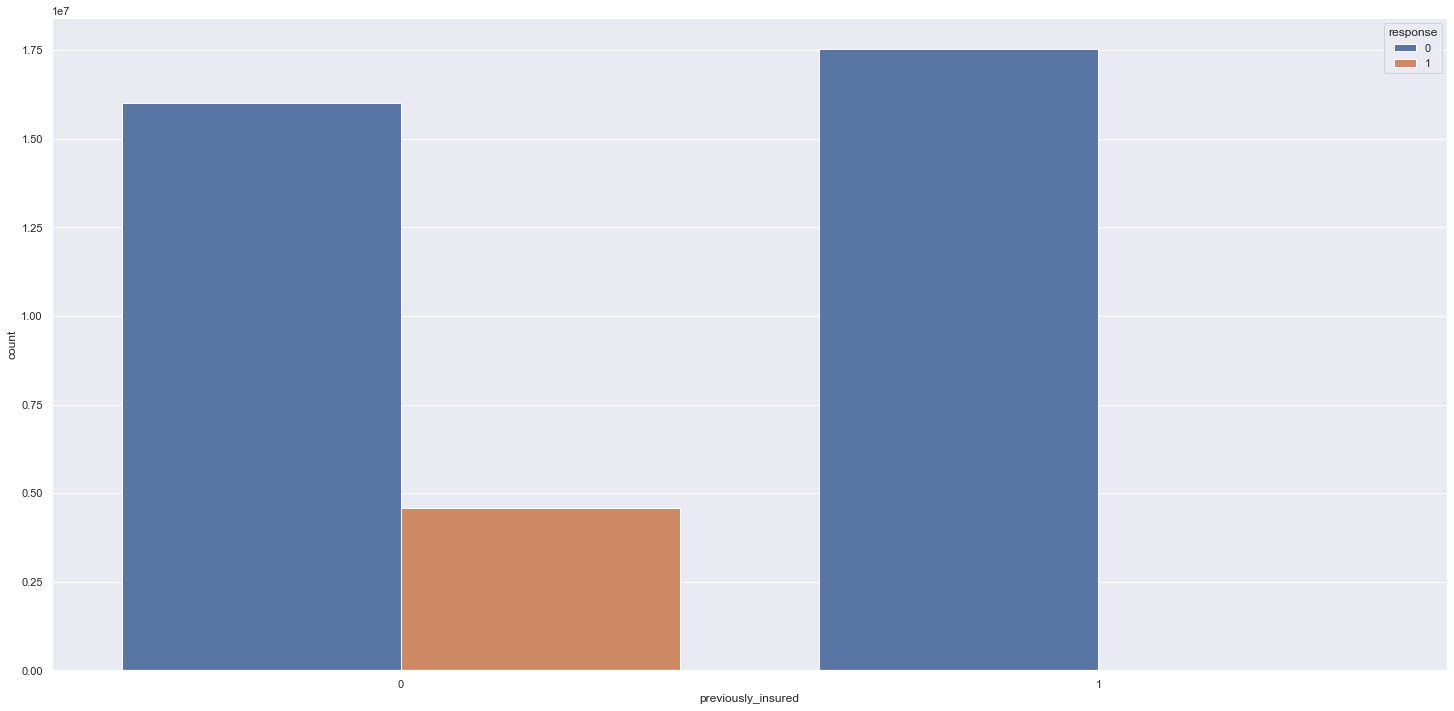

In [115]:
sns.barplot(data=aux4, x='previously_insured', y='count', hue='response');

#### 4.1.2.5 Annual Premium
**Findings** Annual premiums for both interested and non-interested clients are very similar.

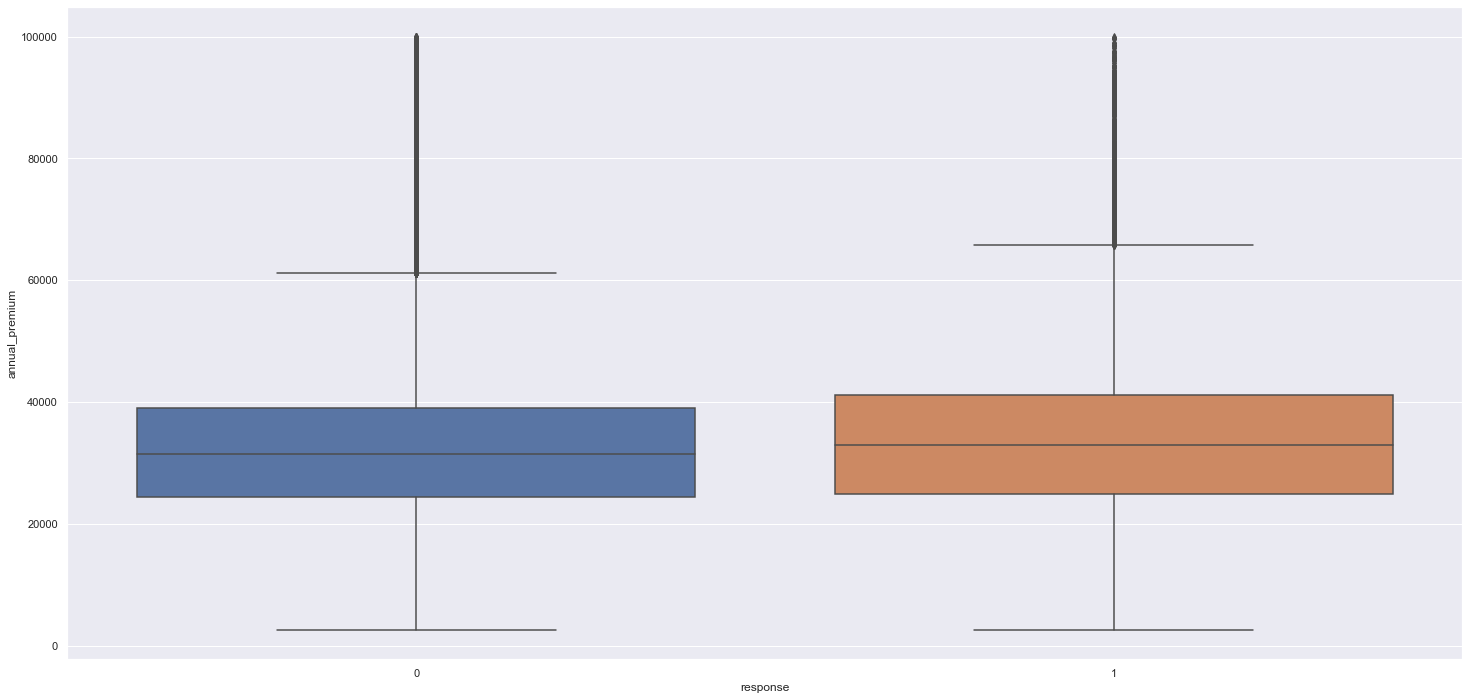

In [116]:
aux5 = df4[(df4['annual_premium'] <100000)]
sns.boxplot( x='response', y='annual_premium', data=aux5 );

#### 4.1.2.6 Policy Sales Channel

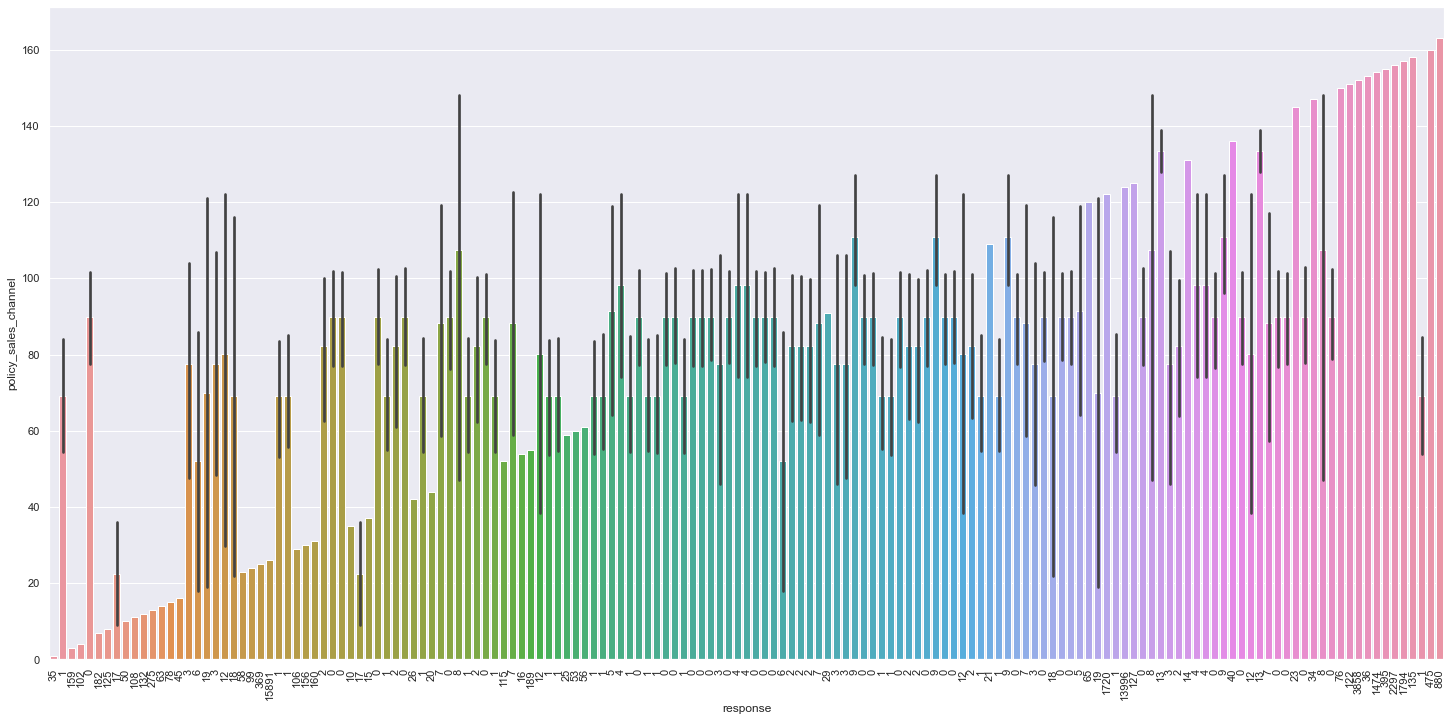

In [117]:
aux6 = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()

plt.xticks(rotation=90)
ax6 = sns.barplot( x='response', y='policy_sales_channel', data=aux6, order = aux6['response']);

#### 4.1.2.7 Vintage

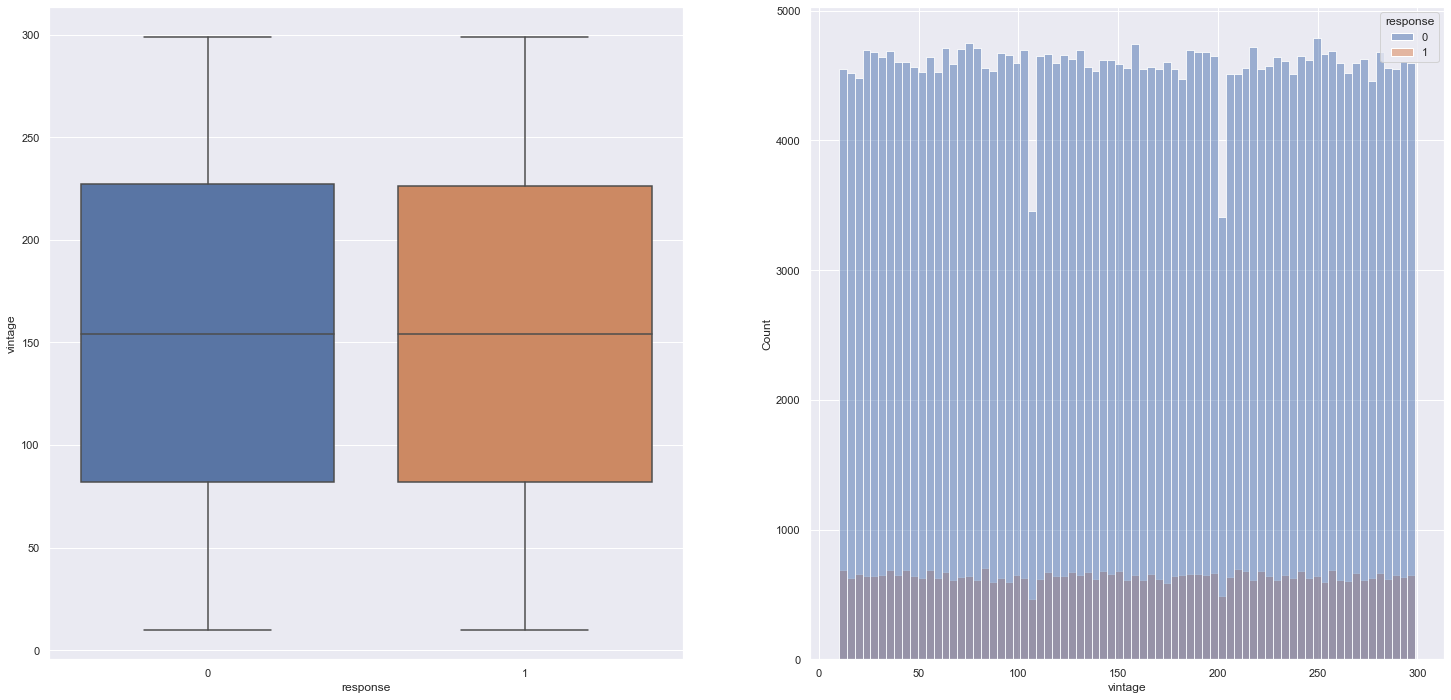

In [118]:
plt.subplot(1, 2, 1)
sns.boxplot( x='response', y='vintage', data=df4 )

plt.subplot(1, 2, 2)
sns.histplot(df4, x='vintage', hue='response');

### 4.1.3 Categorical Variables

#### 4.1.3.1 Gender

In [119]:
aux7=pd.crosstab(df3['gender'], df3['response'])
aux7['percent'] = aux22[1]/(aux22[1]+aux22[0])
aux7

response,0,1,percent
gender,,,
Female,156835,18185,0.103902
Male,177564,28525,0.138411


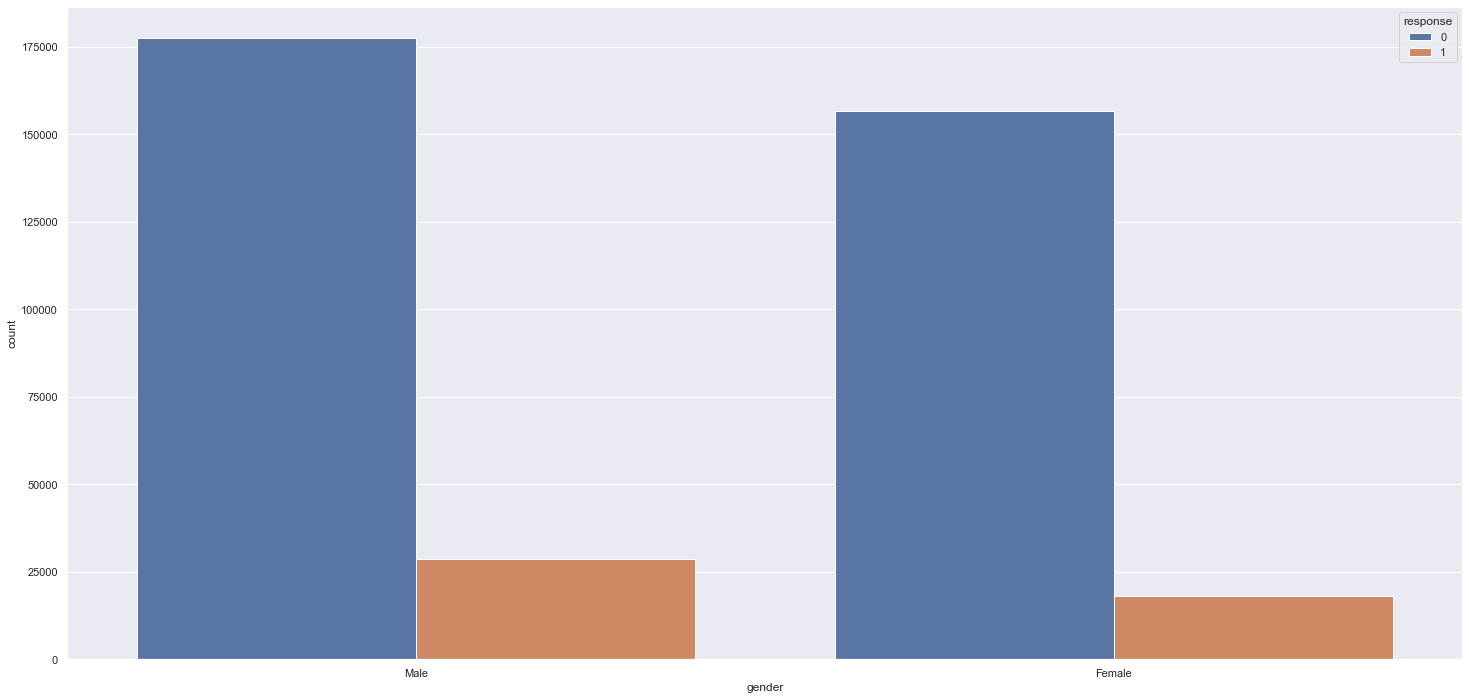

In [120]:
sns.countplot(x= df3['gender'], hue=df3['response']);

#### 4.1.3.2 Vehicle Age

In [121]:
aux8 = pd.DataFrame(round(df4[['vehicle_age', 'response']].value_counts(normalize=True) * 100)).reset_index().rename(columns={0: '%'})
aux8['count'] = (aux8['%'] * df4.shape[0]).astype(int)
aux8

,vehicle_age,response,%,count
0,between_1_2_years,0,43.0,16387687
1,under_1_year,0,41.0,15625469
2,between_1_2_years,1,9.0,3429981
3,over_2_years,0,3.0,1143327
4,under_1_year,1,2.0,762218
5,over_2_years,1,1.0,381109


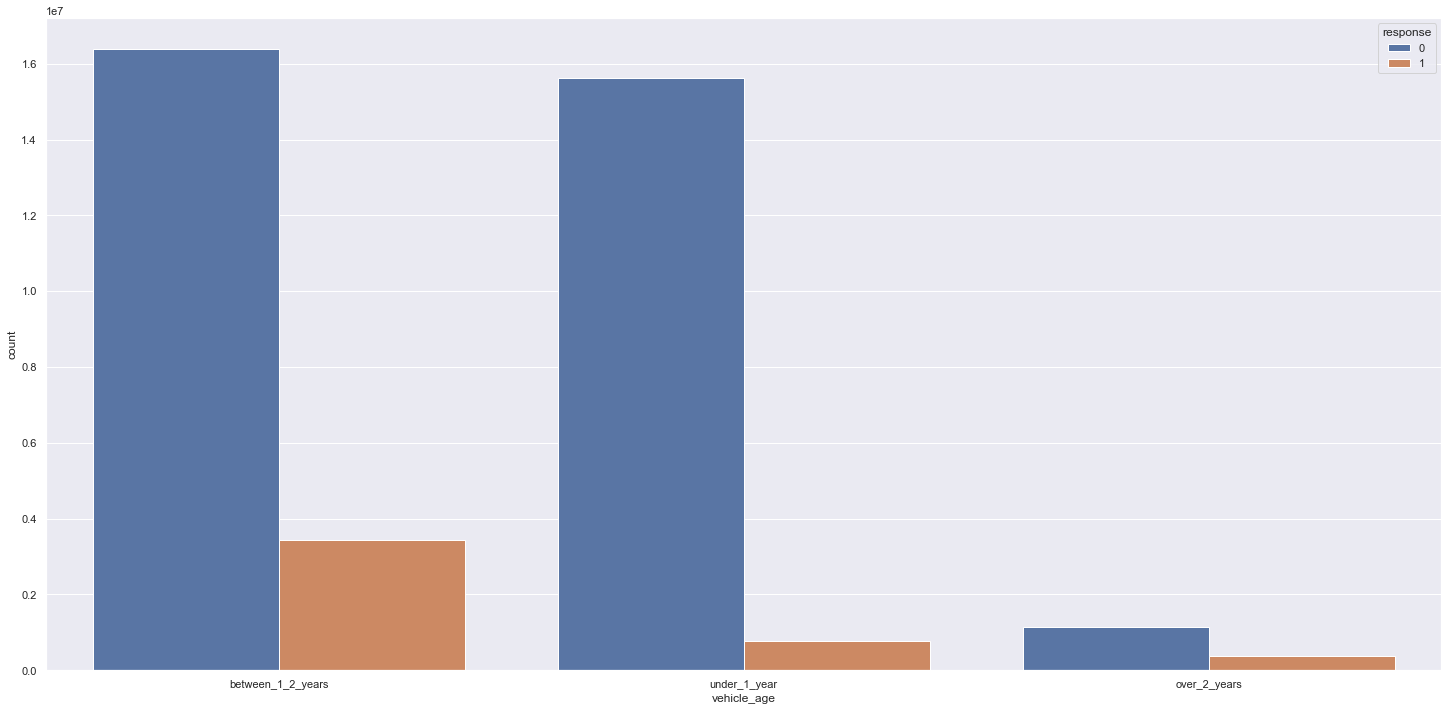

In [122]:
sns.barplot(data=aux8, x='vehicle_age', y='count', hue='response');

#### 4.1.3.3 Vehicle Damage

In [123]:
aux9 = pd.DataFrame(round(df4[['vehicle_damage', 'response']].value_counts(normalize=True) * 100)).reset_index().rename(columns={0: '%'})
aux9['count'] = (aux9['%'] * df4.shape[0]).astype(int)
aux9

,vehicle_damage,response,%,count
0,0,0,49.0,18674341
1,1,0,38.0,14482142
2,1,1,12.0,4573308
3,0,1,0.0,0


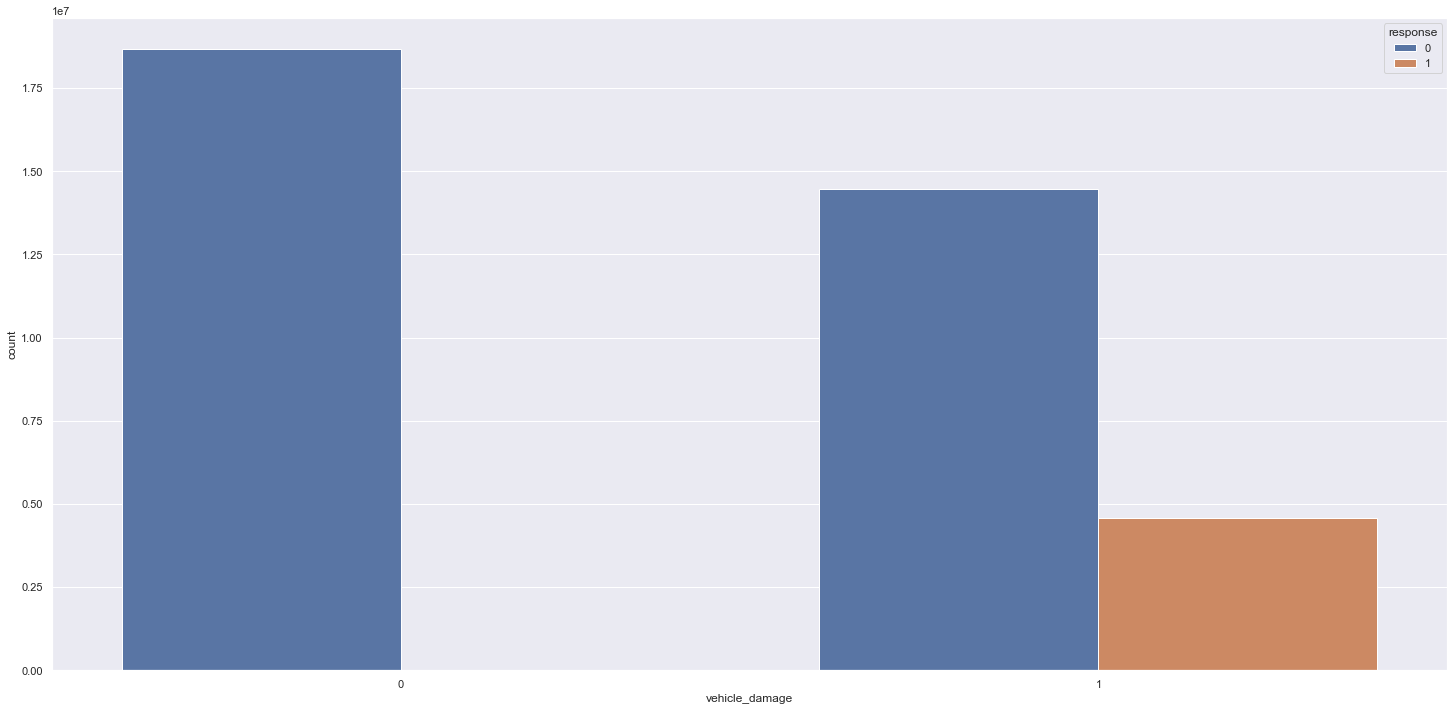

In [124]:
sns.barplot(data=aux9, x='vehicle_damage', y='count', hue='response');

## 4.2 Bivariate Analysis

### 4.2.1 H1. Interest is greater on older people (over 45)
**True** Hypothesis

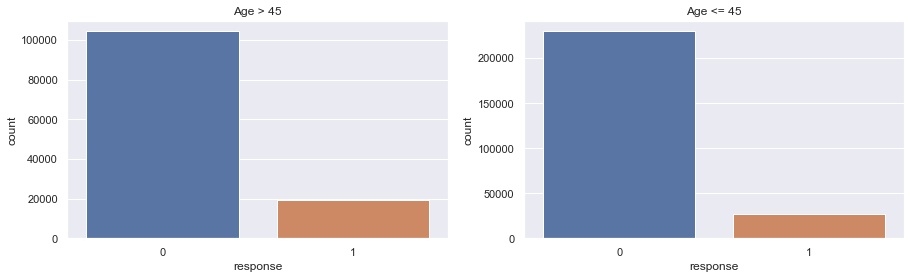

In [126]:
aux211 = df4[df4['age']>45][['id','response']]
aux212 = df4[df4['age']<=45][['id','response']]

fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.countplot(aux211['response'], ax=axs[0]).set_title('Age > 45')
sns.countplot(aux212['response'], ax=axs[1]).set_title('Age <= 45');

In [127]:
print('% Interested in vehicle insurance for people + 45 years old: {0:.2f}'.format(100*(aux211[aux211['response']==1]['response'].count()/(aux211[aux211['response']==1]['response'].count()+aux211[aux211['response']==0]['response'].count()))))
print('% Interested in vehicle insurance for people - 45 years old: {0:.2f}'.format(100*(aux212[aux212['response']==1]['response'].count()/(aux212[aux212['response']==1]['response'].count()+aux212[aux212['response']==0]['response'].count()))))

% Interested in vehicle insurance for people + 45 years old: 15.57
% Interested in vehicle insurance for people - 45 years old: 10.66


### 4.2.2 H2. Interest is greater on female
**False** Hypothesis

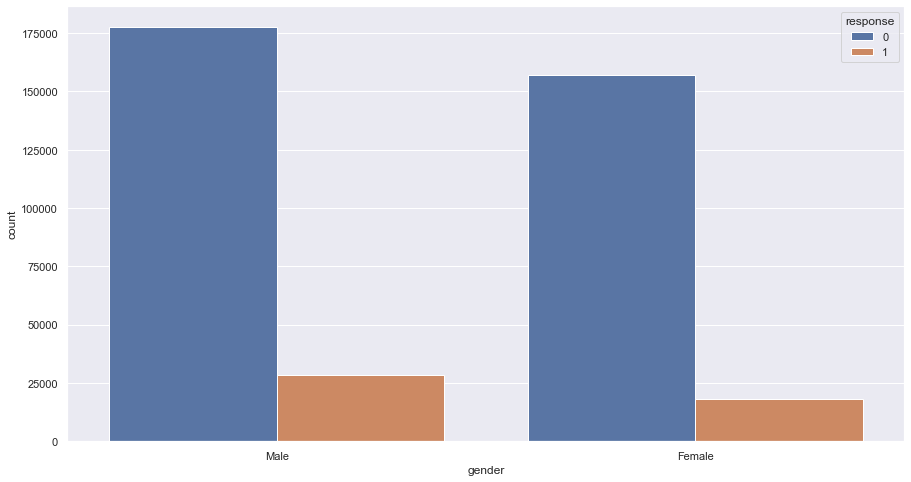

In [128]:
fig, axs = plt.subplots(figsize = (15,8))
sns.countplot(x= df4['gender'], hue=df4['response']);

In [129]:
aux22=pd.crosstab(df4['gender'], df4['response'])
aux22['percentage'] = aux22[1]/(aux22[1]+aux22[0])
aux22

response,0,1,percentage
gender,,,
Female,156835,18185,0.103902
Male,177564,28525,0.138411


### 4.2.3 H3. Interest is greater on customers holding a driving license
**True** Hypothesis

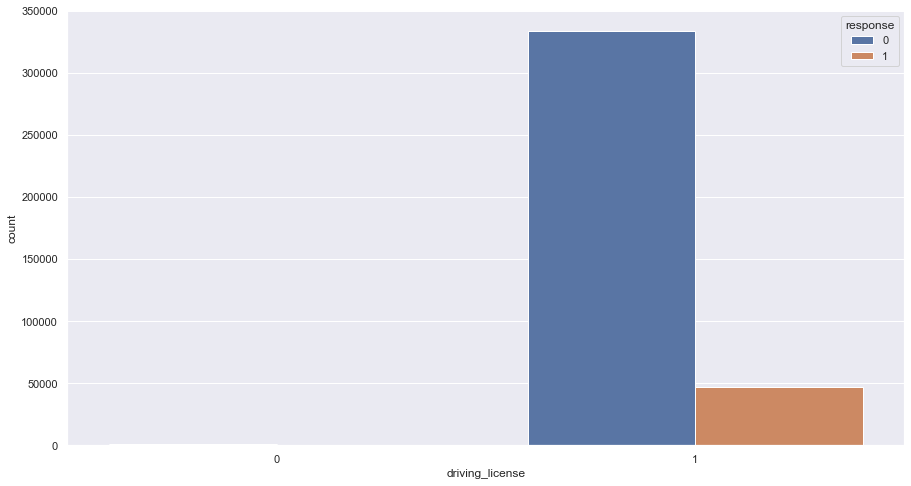

In [130]:
fig, axs = plt.subplots(figsize = (15,8))
sns.countplot(x= df4['driving_license'], hue=df4['response']);

In [131]:
aux23=pd.crosstab(df4['driving_license'], df4['response'])
aux23['percentage'] = aux23[1]/(aux23[1]+aux23[0])
aux23

response,0,1,percentage
driving_license,,,
0,771,41,0.050493
1,333628,46669,0.122717


### 4.2.4 H4. Interest is greater on more time associated users (over 150 days)
**False** Hypothesis

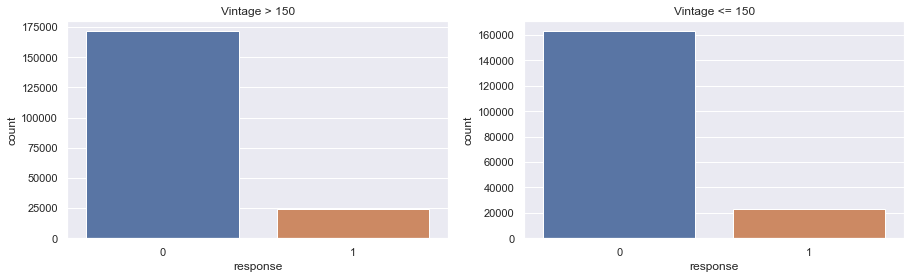

In [132]:
aux241 = df4[df4['vintage']>150][['id','response']]
aux242 = df4[df4['vintage']<=150][['id','response']]

fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.countplot(aux241['response'], ax=axs[0]).set_title('Vintage > 150')
sns.countplot(aux242['response'], ax=axs[1]).set_title('Vintage <= 150');

In [133]:
print('% Interested in vehicle insurance for customers vintage under 150 days: {0:.2f}'.format(100*(aux242[aux242['response']==1]['response'].count()/(aux242[aux242['response']==1]['response'].count()+aux242[aux242['response']==0]['response'].count()))))
print('% Interested in vehicle insurance for customers vintage over 150 days: {0:.2f}'.format(100*(aux241[aux241['response']==1]['response'].count()/(aux241[aux241['response']==1]['response'].count()+aux241[aux241['response']==0]['response'].count()))))

% Interested in vehicle insurance for customers vintage under 150 days: 12.28
% Interested in vehicle insurance for customers vintage over 150 days: 12.24


### 4.2.5 Interest is greater with newer vehicles
**False,** Hypothesis

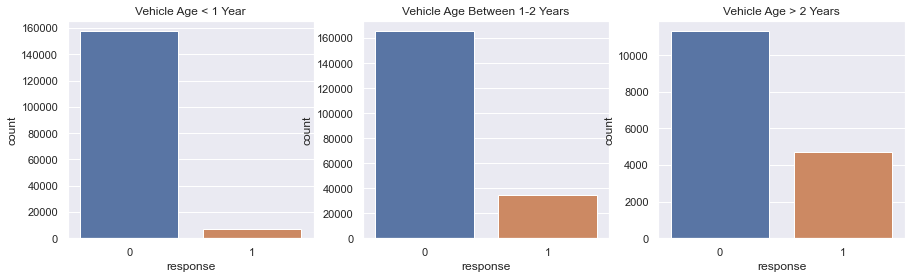

In [137]:
aux251 = df4[df4['vehicle_age']=='under_1_year'][['id','response']]
aux252 = df3[df3['vehicle_age']=='between_1_2_years'][['id','response']]
aux253 = df3[df3['vehicle_age']=='over_2_years'][['id','response']]

fig, axs = plt.subplots(ncols= 3, figsize = (15,4))
sns.countplot(aux251['response'], ax=axs[0]).set_title('Vehicle Age < 1 Year')
sns.countplot(aux252['response'], ax=axs[1]).set_title('Vehicle Age Between 1-2 Years')
sns.countplot(aux253['response'], ax=axs[2]).set_title('Vehicle Age > 2 Years');

In [139]:
print('% Interested in vehicle insurance for customers with cars age under 1 year: {0:.2f}'.format(100*(aux251[aux251['response']==1]['response'].count()/(aux251[aux251['response']==1]['response'].count()+aux251[aux251['response']==0]['response'].count()))))
print('% Interested in vehicle insurance for customers with cars age between 1 and 2 years: {0:.2f}'.format(100*(aux252[aux252['response']==1]['response'].count()/(aux252[aux252['response']==1]['response'].count()+aux252[aux252['response']==0]['response'].count()))))
print('% Interested in vehicle insurance for customers with cars age over 2 years: {0:.2f}'.format(100*(aux253[aux253['response']==1]['response'].count()/(aux253[aux253['response']==1]['response'].count()+aux253[aux253['response']==0]['response'].count()))))

% Interested in vehicle insurance for customers with cars age under 1 year: 4.37
% Interested in vehicle insurance for customers with cars age between 1 and 2 years: 17.38
% Interested in vehicle insurance for customers with cars age over 2 years: 29.37


### 4.2.6 Interest is greater with previously damaged vehicles
**True,** Hypothesis

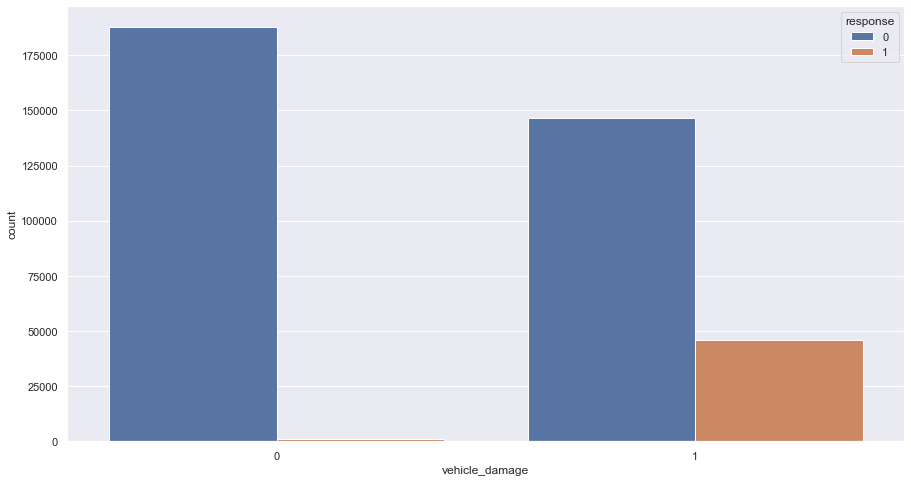

In [142]:
fig, axs = plt.subplots(figsize = (15,8))
sns.countplot(df4['vehicle_damage'], hue=df4['response']);

In [145]:
aux26=pd.crosstab(df4['vehicle_damage'], df4['response'])
aux26['percentage'] = aux26[1]/(aux26[1]+aux26[0])
aux26

response,0,1,percentage
vehicle_damage,,,
0,187714,982,0.005204
1,146685,45728,0.237655


### 4.2.7 Interest is greater on previously insured owners
**False,** Hypothesis

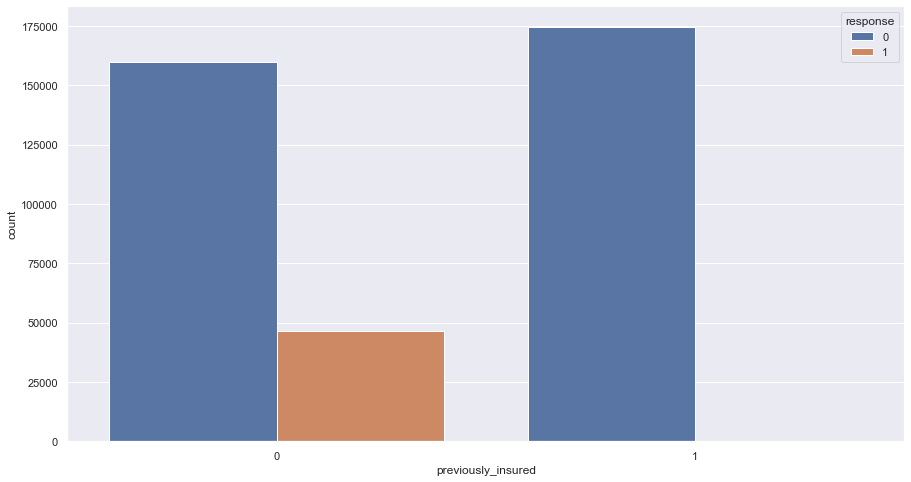

In [144]:
fig, axs = plt.subplots( figsize = (15,8))
sns.countplot(df4['previously_insured'], hue=df4['response']);

In [146]:
aux27=pd.crosstab(df4['previously_insured'], df4['response'])
aux27['percentage'] = aux27[1]/(aux27[1]+aux27[0])
aux27

response,0,1,percentage
previously_insured,,,
0,159929,46552,0.225454
1,174470,158,0.000905


### 2.4.8 Interest is greater on higher annual premiums (over 30k/year)
**False,** Hypothesis

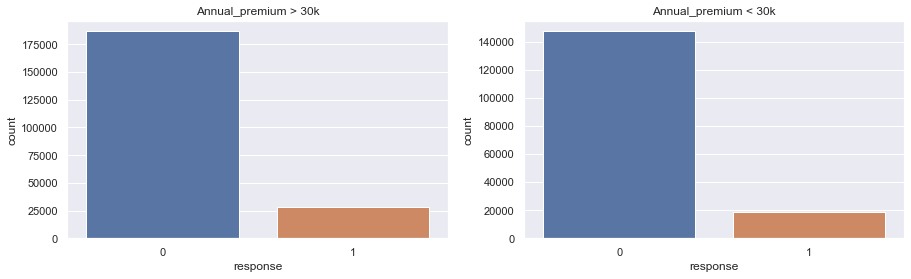

In [149]:
aux281 = df4[df4['annual_premium']>30000][['id','response']]
aux282 = df4[df4['annual_premium']<=30000][['id','response']]

fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.countplot(aux281['response'], ax=axs[0]).set_title('Annual_premium > 30k')
sns.countplot(aux282['response'], ax=axs[1]).set_title('Annual_premium < 30k');

In [151]:
print('% Interested in vehicle insurance for customers with health insurance premium under 30k/year: {0:.2f}'.format(100*(aux252[aux252['response']==1]['response'].count()/(aux252[aux252['response']==1]['response'].count()+aux252[aux252['response']==0]['response'].count()))))
print('% Interested in vehicle insurance for customers with health insurance premium over 30k/year: {0:.2f}'.format(100*(aux251[aux251['response']==1]['response'].count()/(aux251[aux251['response']==1]['response'].count()+aux251[aux251['response']==0]['response'].count()))))

% Interested in vehicle insurance for customers with health insurance premium under 30k/year: 17.38
% Interested in vehicle insurance for customers with health insurance premium over 30k/year: 4.37


## Multivariate Analysis

### Numerical Attributed
**Finding** Having the target variable in scope, the stronger correlations with feature 'Previously Insured' (-0.34), 'Policy Sales Channel' (-0.14) and 'Age' (0.11). Outside the target variable scope, between Age and Policy Sales Chanel there is strong negative correlation of -0.58), 'Previously Insured' and 'Age' of -0.25 and last between 'Previously Insured' and 'Policy Sales Channel' 0.22. 

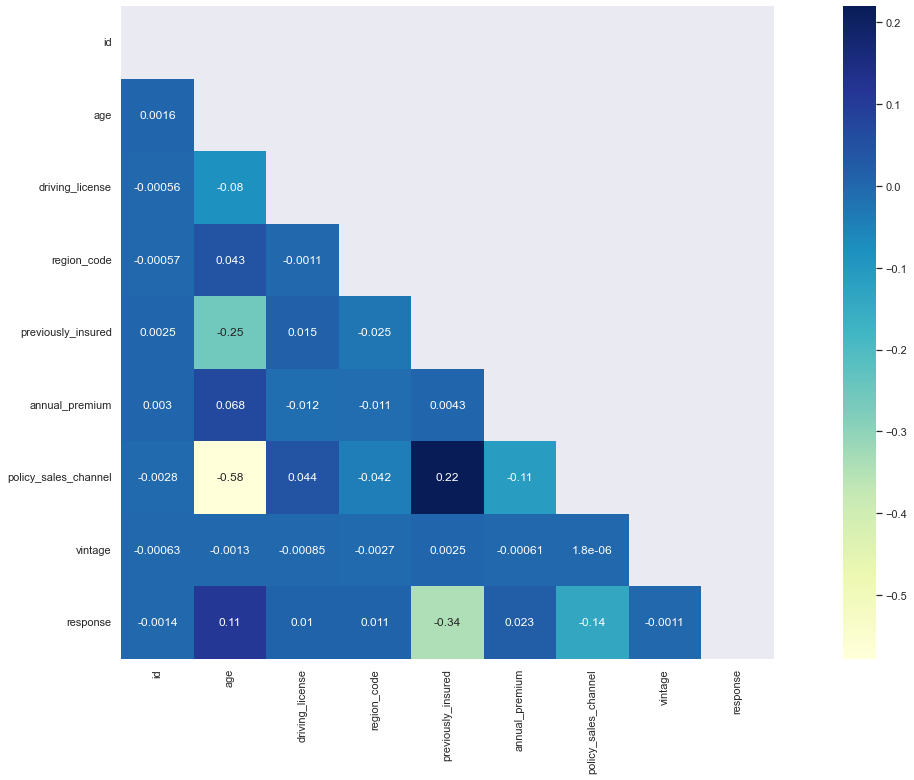

In [152]:
corr_matrix= num_attributes.corr()
# Half matrix
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_matrix, mask = mask, annot = True, square = True, cmap='YlGnBu');

# Data Preparation

In [153]:
df5 = df4.copy()

## Standardization of DataSets 

In [154]:
df5['annual_premium'] = StandardScaler().fit_transform( df5[['annual_premium']].values)

## Rescaling

In [155]:
mms = MinMaxScaler()

#age
df5['age'] = mms.fit_transform( df5[['age']].values)

#vintage
df5['vintage'] = mms.fit_transform( df5[['vintage']].values)

## Transformation

### Encoding

In [156]:
#gender - target encoder
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map(target_encode_gender)

# region_code - Target Encoding - as there are plenty of categories (as seen in EDA) it is better not to use one hot encoding and to use 
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encode_region_code)

#vehicle_age
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

#policy_sales_channel - Frequency encode
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size()/len( df5)
df5['policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)

# Feature Selection

In [157]:
df6 = df5.copy()

## Split dataframe into training and test

In [158]:
X = df6.drop('response', axis=1)
y = df6['response'].copy()

x_train, x_val, y_train, y_val = model_selection.train_test_split(X, y, test_size = 0.2)

df6 = pd.concat ( [x_train, y_train], axis = 1)

## Feature Importance

In [159]:
forest = ensemble.ExtraTreesClassifier( n_estimators = 250, random_state = 42, n_jobs = -1)

x_train_n = df6.drop(['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=42)

Feature Rankings
                         feature  importance
0                        vintage    0.272885
0                 annual_premium    0.244691
0                            age    0.164618
0                    region_code    0.106032
0                 vehicle_damage    0.072304
0           policy_sales_channel    0.061371
0             previously_insured    0.050704
0       vehicle_age_under_1_year    0.013684
0  vehicle_age_between_1_2_years    0.005865
0                         gender    0.005136
0       vehicle_age_over_2_years    0.002253
0                driving_license    0.000458


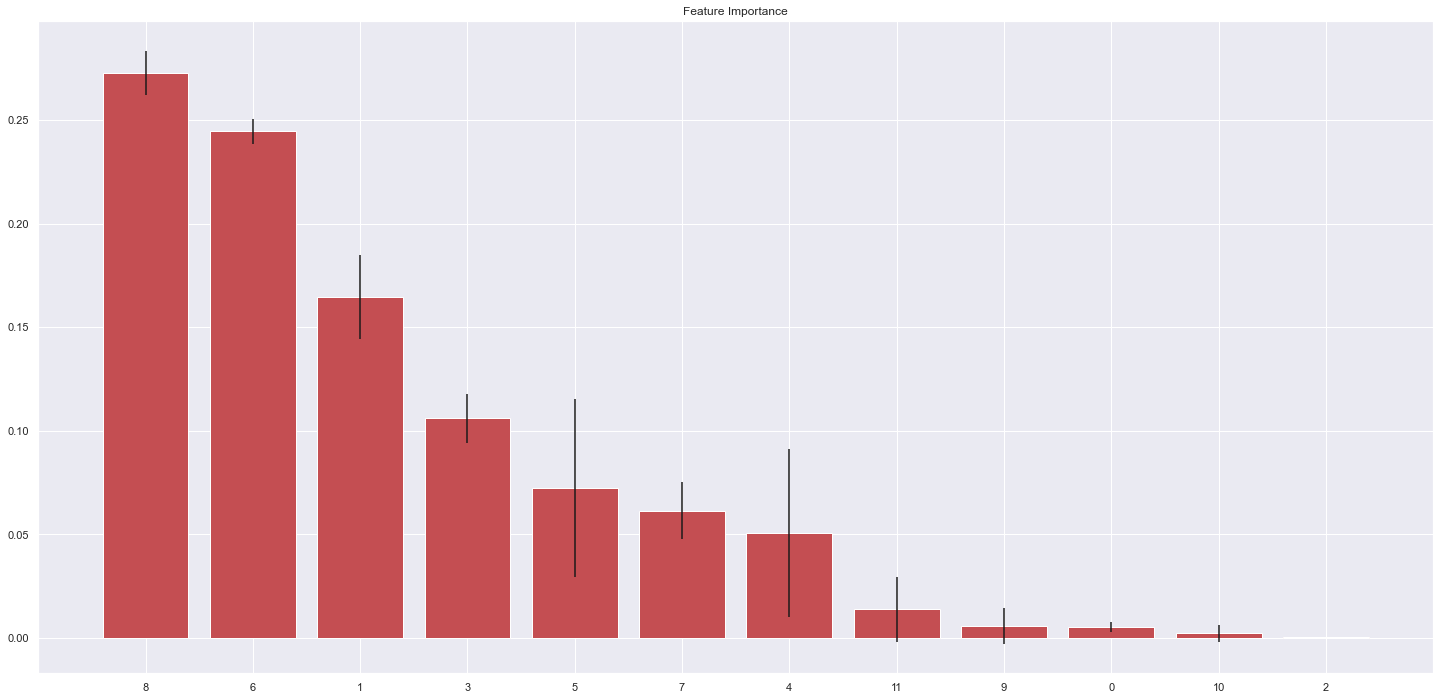

In [160]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
indices = np.argsort(importances)[::-1]
#print the feature ranking
print( "Feature Rankings")
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame( {'feature': i, 'importance':j}, index=[0])
    df = pd.concat ([df, aux], axis = 0)
    
print( df.sort_values( 'importance', ascending=False))

# PLt the impurity-based feature importance of the features
plt.figure()
plt.title('Feature Importance')
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# Machine Learning Modelling

In [162]:
#I will use as well 'driving_license' as it seemes an importante feature in EDA
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 
                 'vehicle_damage', 'policy_sales_channel', 'driving_license']

cols_not_selected = ['previously_insured', 'vehicle_age_between_1_2_years', 'vehicle_age_under_1_year', 'gender', 'vehicle_age_over_2_years']

#create df to be used for business understading
x_validation = x_val.drop(cols_not_selected, axis=1)

#create dfs for modeling
x_train = df6[cols_selected]
x_val = x_val[cols_selected]

## Logistic Regression

### Model Building

In [163]:
#define model
lr = linear_model.LogisticRegression (random_state = 42)

#train model
lr.fit( x_train, y_train)

#model prediction
yhat_lr = lr.predict_proba( x_val)

### Model Single Performance

In [164]:
accuracy_lr = accuracy(lr, x_val, y_val, yhat_lr)
accuracy_lr

,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,LogisticRegression,0.8049,0.2889,0.584,0.387


### Cross Validation Performance

In [165]:
accuracy_cv_lr = cross_validation(lr, x_train, y_train, 5, df6, Verbose = True)
accuracy_cv_lr

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,LogisticRegression,0.8039,0.2759,0.7204,0.399


### Performance Plotted

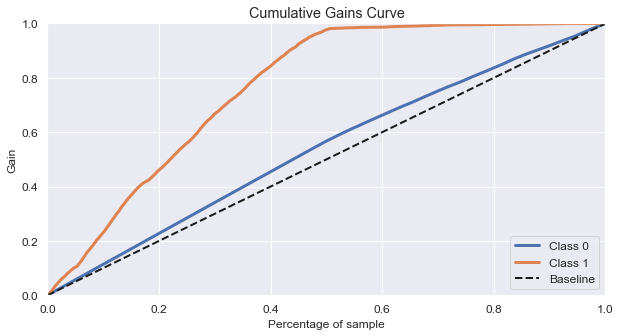

In [166]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr, figsize = (10, 5));

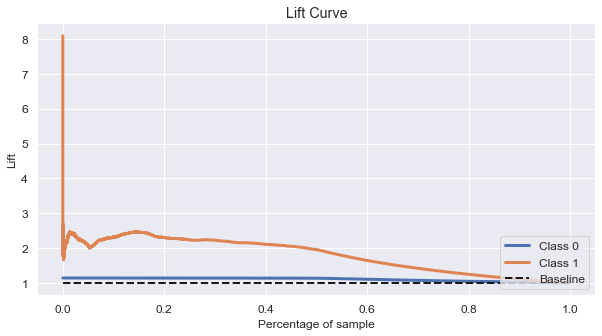

In [167]:
# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_lr, figsize = (10, 5) );

## Naive Bayes

### Model Building

In [168]:
#define model
naive = GaussianNB()

#train model
naive.fit( x_train, y_train)

#model prediction
yhat_naive = naive.predict_proba( x_val)

### Model Single Performance

In [169]:
accuracy_naive = accuracy(naive, x_val, y_val, yhat_naive)
accuracy_naive

,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,GaussianNB,0.8147,0.2979,0.6121,0.401


### Cross Validation Performance

In [170]:
accuracy_cv_naive = cross_validation(naive, x_train, y_train, 5, df6, Verbose = True)
accuracy_cv_naive

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,GaussianNB,0.8135,0.2839,0.7514,0.412


### Performance Plotted

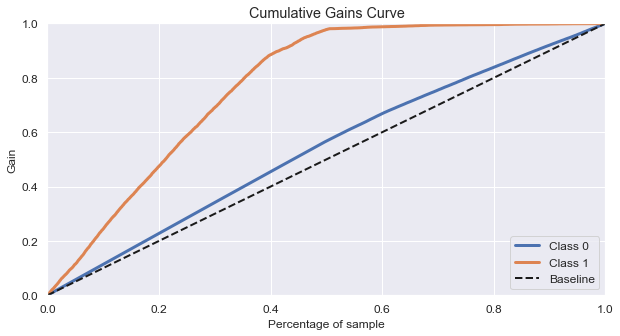

In [171]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_naive, figsize = (10, 5));

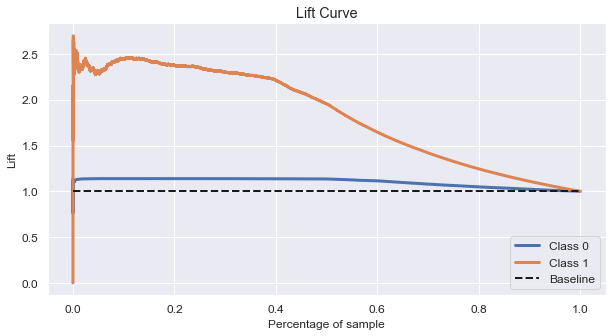

In [172]:
# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_naive, figsize = (10, 5) );

## Extra Trees

### Model Building

In [173]:
#define model
et = ensemble.ExtraTreesClassifier (random_state = 42, n_jobs=-1)

#train model
et.fit( x_train, y_train)

#model prediction
yhat_et = et.predict_proba( x_val)

### Model Single Performance

In [174]:
accuracy_et = accuracy(et, x_val, y_val, yhat_et)
accuracy_et

,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,ExtraTreesClassifier,0.8101,0.3458,0.6236,0.445


### Cross Validation Performance

In [175]:
accuracy_cv_et = cross_validation(et, x_train, y_train, 5, df6, Verbose = True)
accuracy_cv_et

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,ExtraTreesClassifier,0.8093,0.3188,0.7475,0.447


### Performance Plotted

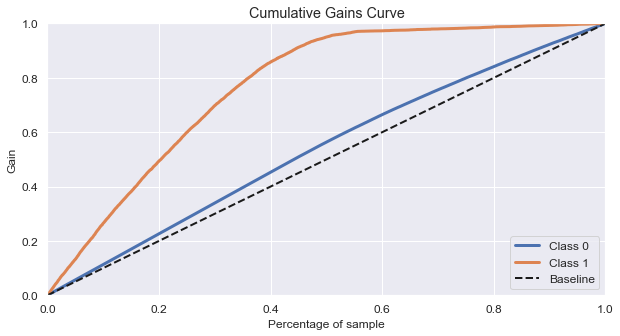

In [176]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_et, figsize = (10, 5));

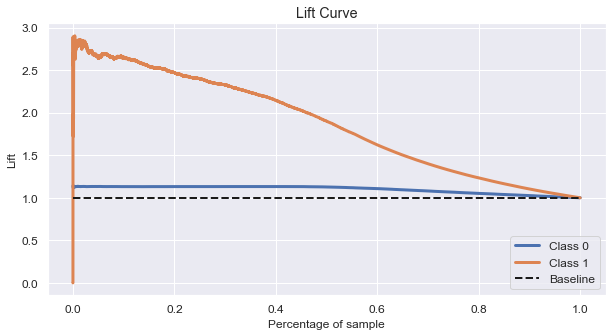

In [177]:
# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_et, figsize = (10, 5) );

## Random Forest Regressor

### Model Building

In [178]:
#define model
rf=RandomForestClassifier(n_estimators=100, min_samples_leaf=25)

#train model
rf.fit( x_train, y_train)

#model prediction
yhat_rf = rf.predict_proba( x_val)

### Model Single Performance

In [179]:
accuracy_rf = accuracy(rf, x_val, y_val, yhat_rf)
accuracy_rf

,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,RandomForestClassifier,0.8435,0.4038,0.6878,0.509


### Cross Validation Performance

In [180]:
accuracy_cv_rf = cross_validation(rf, x_train, y_train, 5, df6, Verbose = True)
accuracy_cv_rf

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,RandomForestClassifier,0.8444,0.4163,0.8083,0.55


### Performance Plotted

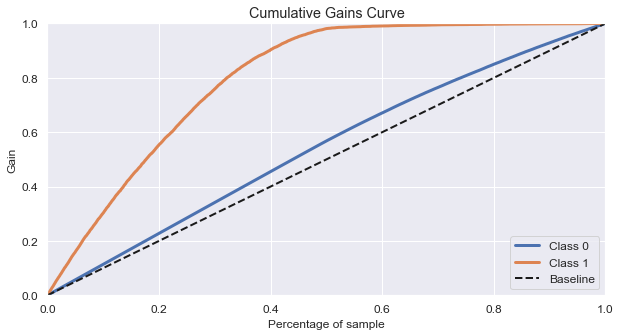

In [181]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf, figsize = (10, 5));

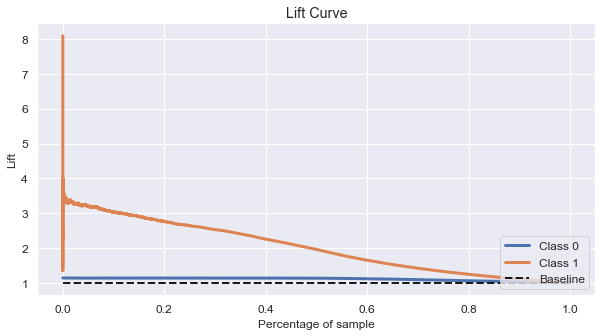

In [182]:
# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_rf, figsize = (10, 5) );

## KNN Classifier

### Model Building

In [183]:
#define model
knn = neighbors.KNeighborsClassifier (n_neighbors = 8)

#train model
knn.fit( x_train, y_train)

#model prediction
yhat_knn = knn.predict_proba( x_val)

### Model Single Performance

In [184]:
accuracy_knn = accuracy(knn, x_val, y_val, yhat_knn)
accuracy_knn

,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,KNeighborsClassifier,0.7798,0.3293,0.6128,0.428


### Cross Validation Performance

In [185]:
accuracy_cv_knn = cross_validation(knn, x_train, y_train, 5, df6, Verbose = True)
accuracy_cv_knn

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,KNeighborsClassifier,0.781,0.3438,0.7246,0.466


### Performance Plotted

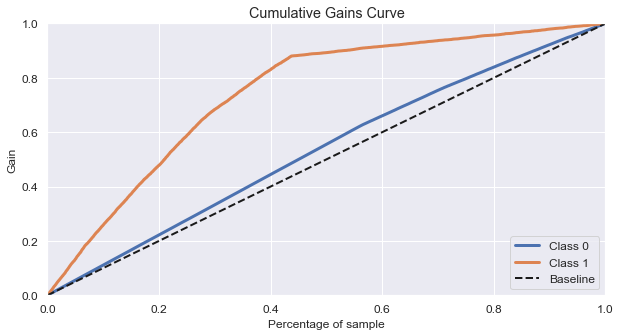

In [186]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn, figsize = (10, 5));

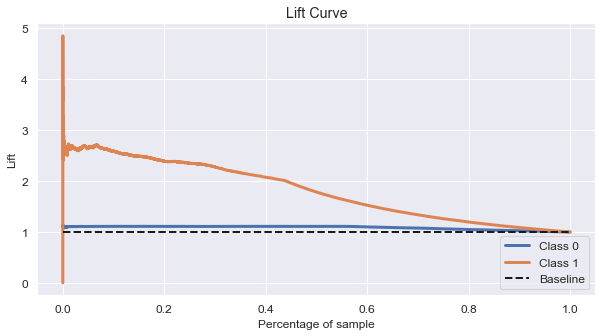

In [187]:
# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_knn, figsize = (10, 5) );

### Cross Validation

## XGBoost Classifier

### Model Building

In [188]:
#define model
xgboost = XGBClassifier(objective='binary:logistic',
                        eval_metric='error',
                        n_estimators = 100,
                        random_state = 22)

#train model
xgboost.fit( x_train, y_train)

#model prediction
yhat_xgboost = xgboost.predict_proba( x_val)

### Model Single Performance

In [189]:
accuracy_xgboost = accuracy(xgboost, x_val, y_val, yhat_xgboost)
accuracy_xgboost

,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,XGBClassifier,0.8446,0.4068,0.6893,0.512


### Cross Validation Performance

In [190]:
accuracy_cv_xgboost = cross_validation(xgboost, x_train, y_train, 5, df6, Verbose = True)
accuracy_cv_xgboost

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,XGBClassifier,0.8437,0.4068,0.8075,0.541


### Performance Plotted

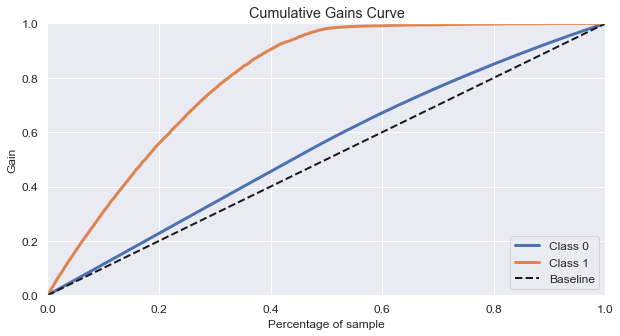

In [191]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgboost, figsize = (10, 5));

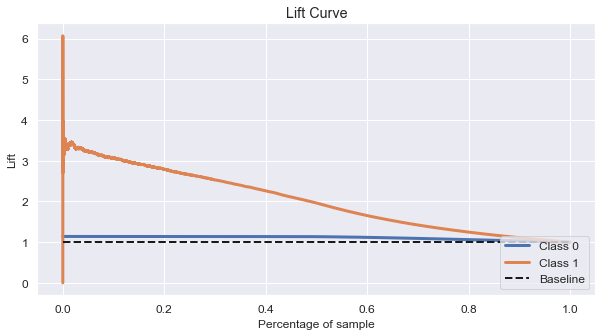

In [192]:
# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_xgboost, figsize = (10, 5) );

## LightGBM Classifier

### Model Building

In [193]:
#define model
lgbm = LGBMClassifier(random_state = 22)

#train model
lgbm.fit( x_train, y_train)

#model prediction
yhat_lgbm = lgbm.predict_proba( x_val)

### Model Single Performance

In [194]:
accuracy_lgbm = accuracy(lgbm, x_val, y_val, yhat_lgbm)
accuracy_lgbm

,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,LGBMClassifier,0.8459,0.4228,0.6924,0.525


### Cross Validation Performance

In [195]:
accuracy_cv_lgbm = cross_validation(lgbm, x_train, y_train, 5, df6, Verbose = True)
accuracy_cv_lgbm

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,LGBMClassifier,0.8462,0.4233,0.8127,0.557


### Performance Plotted

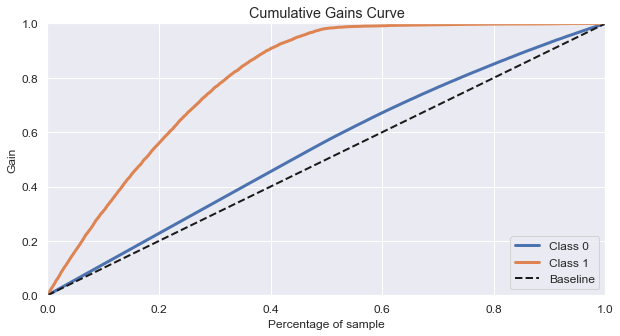

In [196]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lgbm, figsize = (10, 5));

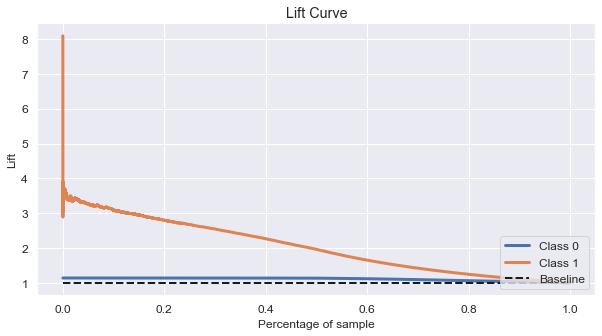

In [197]:
# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_lgbm, figsize = (10, 5) );

## CatBoost Classifier

### Model Building

In [198]:
#define model
catboost = CatBoostClassifier(verbose = False, random_state = 22)

#train model
catboost.fit( x_train, y_train)

#model prediction
yhat_catboost = catboost.predict_proba( x_val)

### Model Single Performance

In [199]:
accuracy_catboost = accuracy(catboost, x_val, y_val, yhat_catboost)
accuracy_catboost

,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,CatBoostClassifier,0.8449,0.4138,0.692,0.518


### Cross Validation Performance

In [200]:
accuracy_cv_catboost = cross_validation(catboost, x_train, y_train, 5, df6, Verbose = True)
accuracy_cv_catboost

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,CatBoostClassifier,0.8452,0.4228,0.8091,0.555


### Performance Plotted

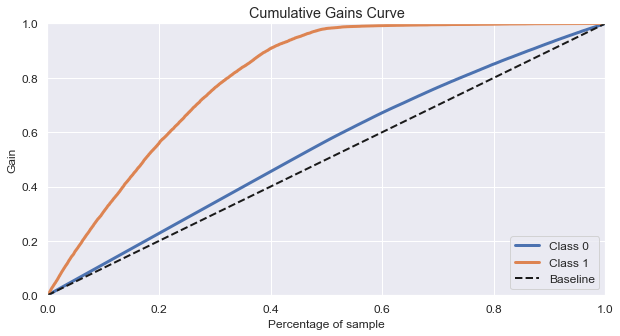

In [201]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_catboost, figsize = (10, 5));

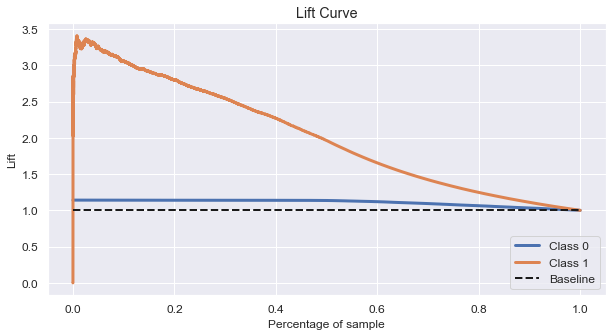

In [202]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_catboost, figsize=(10, 5));

## Comparing Models Preformance

### Single Performance

In [203]:
models_results = pd.concat([accuracy_lr, accuracy_naive, accuracy_et, accuracy_rf, accuracy_knn, accuracy_xgboost, accuracy_lgbm, accuracy_catboost])
models_results.sort_values('Recall@K Mean', ascending = False)

,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,LGBMClassifier,0.8459,0.4228,0.6924,0.525
0,CatBoostClassifier,0.8449,0.4138,0.6920,0.518
0,XGBClassifier,0.8446,0.4068,0.6893,0.512
0,RandomForestClassifier,0.8435,0.4038,0.6878,0.509
0,ExtraTreesClassifier,0.8101,0.3458,0.6236,0.445
0,KNeighborsClassifier,0.7798,0.3293,0.6128,0.428
0,GaussianNB,0.8147,0.2979,0.6121,0.401
0,LogisticRegression,0.8049,0.2889,0.5840,0.387


### Cross Validation Performance

In [204]:
models_results_cv = pd.concat([accuracy_cv_lr, accuracy_cv_naive, accuracy_cv_et, accuracy_cv_rf, accuracy_cv_knn, accuracy_cv_xgboost, accuracy_cv_lgbm, accuracy_cv_catboost])
models_results_cv.sort_values('Recall@K Mean', ascending = False)

,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,LGBMClassifier,0.8462,0.4233,0.8127,0.557
0,CatBoostClassifier,0.8452,0.4228,0.8091,0.555
0,RandomForestClassifier,0.8444,0.4163,0.8083,0.550
0,XGBClassifier,0.8437,0.4068,0.8075,0.541
0,GaussianNB,0.8135,0.2839,0.7514,0.412
0,ExtraTreesClassifier,0.8093,0.3188,0.7475,0.447
0,KNeighborsClassifier,0.7810,0.3438,0.7246,0.466
0,LogisticRegression,0.8039,0.2759,0.7204,0.399


# Hyperparameter Fine Tuning

## Random Search

In [214]:
import random

param = {'num_leaves' : [2, 5, 10, 30, 50],
         'max_depth' : [-1, 0, 1, 5, 20],
         'num_iterations': [50, 100],
         'learning_rate' : [0.001, 0.01, 0.1, 0.2, 0.3],
         'random_state' : [22]
        }

MAX_EVAL = 10

In [215]:
final_result = pd.DataFrame({'ROC AUC': [], 'Precision@K Mean': [], 'Recall@K Mean': [], 'F1_Score': [] })

for i in range ( MAX_EVAL ):
    
    ## choose randomly values for parameters
    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
    print( 'Step ' +str(i +1) + '/' + str(MAX_EVAL))
    print( hp )
    # model
    model_lgbm = LGBMClassifier(num_leaves=hp['num_leaves'],
                                max_depth = hp['max_depth'],
                                num_iterations = hp['num_iterations'],
                                learning_rate=hp['learning_rate'],
                                random_state=hp['random_state'])
                                      

    # performance
    model_lgbm_result = cross_validation(model_lgbm, x_train, y_train, 5, df6, Verbose = False)
    final_result = pd.concat([final_result, model_lgbm_result])
    
final_result.sort_values('Recall@K Mean', ascending = False)

Step 1/10
{'num_leaves': 50, 'max_depth': 5, 'num_iterations': 100, 'learning_rate': 0.1, 'random_state': 22}
Step 2/10
{'num_leaves': 2, 'max_depth': 5, 'num_iterations': 50, 'learning_rate': 0.01, 'random_state': 22}
Step 3/10
{'num_leaves': 10, 'max_depth': -1, 'num_iterations': 100, 'learning_rate': 0.01, 'random_state': 22}
Step 4/10
{'num_leaves': 5, 'max_depth': -1, 'num_iterations': 100, 'learning_rate': 0.2, 'random_state': 22}
Step 5/10
{'num_leaves': 10, 'max_depth': -1, 'num_iterations': 100, 'learning_rate': 0.001, 'random_state': 22}
Step 6/10
{'num_leaves': 5, 'max_depth': 20, 'num_iterations': 100, 'learning_rate': 0.3, 'random_state': 22}
Step 7/10
{'num_leaves': 30, 'max_depth': 0, 'num_iterations': 50, 'learning_rate': 0.2, 'random_state': 22}
Step 8/10
{'num_leaves': 50, 'max_depth': 5, 'num_iterations': 50, 'learning_rate': 0.2, 'random_state': 22}
Step 9/10
{'num_leaves': 30, 'max_depth': 20, 'num_iterations': 50, 'learning_rate': 0.2, 'random_state': 22}
Step 10/

,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score,Model Name
0,0.8462,0.4243,0.8126,0.557,LGBMClassifier
0,0.8459,0.4163,0.8123,0.550,LGBMClassifier
0,0.8448,0.4163,0.8119,0.550,LGBMClassifier
0,0.8448,0.4163,0.8119,0.550,LGBMClassifier
0,0.8455,0.4188,0.8116,0.552,LGBMClassifier
0,0.8458,0.4223,0.8107,0.555,LGBMClassifier
0,0.8409,0.4018,0.8044,0.536,LGBMClassifier
0,0.8376,0.3998,0.7995,0.533,LGBMClassifier
0,0.7701,0.2454,0.6468,0.356,LGBMClassifier
0,0.7701,0.2454,0.6468,0.356,LGBMClassifier


## Final Model
**The best parameters are the standard used by the Classifier**

In [218]:
#define model
lgbm_tuned = LGBMClassifier(random_state = 22)

#train model
lgbm_tuned = lgbm_tuned.fit( x_train, y_train)

#model prediction
yhat_lgbm_tuned = lgbm_tuned.predict_proba( x_val)

In [219]:
accuracy_lgbm_tuned = cross_validation(lgbm_tuned, x_train, y_train, 5, df6, Verbose = False)
accuracy_lgbm_tuned

,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,LGBMClassifier,0.8462,0.4233,0.8127,0.557


# Performance Evaluation and Interpretation

## Key findings on interested customers most relevant attributes

### Insight #1:

### Insight #2:

### Insight #3:

## What percentage of interested customers the sales team will be able to contact making 20.000 calls?

In [220]:
# Define dataset to apply final model
df9 = x_val.copy()
df9['response'] = y_val.copy()
df9['score'] = yhat_lgbm_tuned[:, 1].tolist()
df9 = df9.sort_values('score', ascending=False)

# Define dataset percentage that defines 20.000 calls
percent = round((20000/len(df9)*100), 2)
# Apply Recall metric to define the percentage of interested customers was achieved by phone calling 20.000 people
recall_at_20000 = round((recall_at_k(df9))*100 , 2 )

print(f'Using {percent}% of the test data, the model could find {recall_at_20000}% of the total customers interested in purchase a car insurance.')

Using 26.24% of the test data, the model could find 69.24% of the total customers interested in purchase a car insurance.


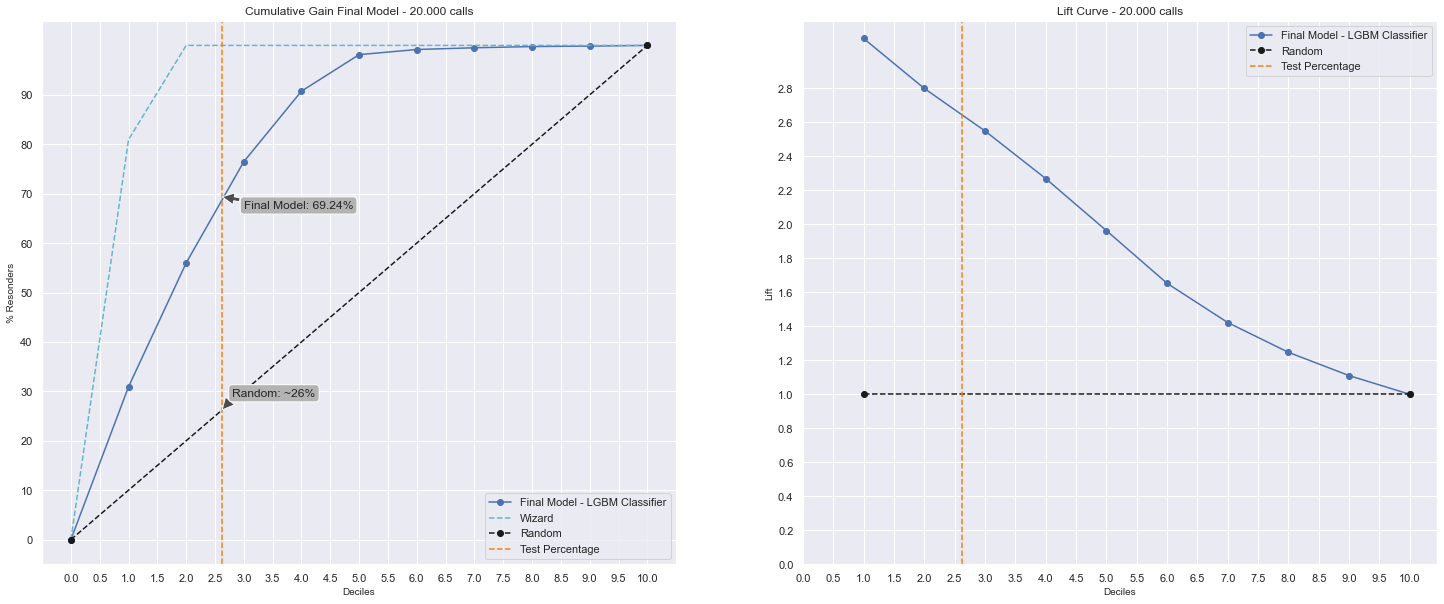

In [222]:
fig, ax = plt.subplots(figsize = (25, 10))

plt.subplot(1, 2, 1)
plot_cumulative_gain(y_val, yhat_lgbm_tuned[:,1])
plt.axvline(2.624, color ='#FF7F0E', ls = '--')
plt.title('Cumulative Gain Final Model - 20.000 calls')
plt.yticks(np.arange(0, 100, step = 10))
plt.xticks(np.arange(0, 10.5, step = 0.5))
plt.legend(['Final Model - LGBM Classifier', 'Wizard', 'Random', 'Test Percentage'])

bbox = dict(boxstyle ='round', fc ='0.7')
arrowprops = dict(facecolor ='#4D4D4D')
plt.annotate('Final Model: 69.24%', xy = (2.624, 69.37),
                xytext =(3, 67), 
                arrowprops = arrowprops, bbox = bbox)

plt.annotate('Random: ~26%', xy = (2.624, 26.24),
                xytext =(2.8, 29), 
                arrowprops = arrowprops, bbox = bbox);



plt.subplot(1, 2, 2)
plot_lift(y_val, yhat_lgbm_tuned[:,1])
plt.axvline(2.624, color ='#FF7F0E', ls = '--')
plt.title('Lift Curve - 20.000 calls')
plt.yticks(np.arange(0, 3, step = 0.2))
plt.xticks(np.arange(0, 10.5, step = 0.5))
plt.legend(['Final Model - LGBM Classifier', 'Random', 'Test Percentage']);

## By increasing the capacity to 40,000 calls, what percentage of interested customers the sales team will be able to contact?

In [223]:
# Define dataset percentage that defines 40.000 calls
percent = round((40000/len(df9)*100), 2)
# Apply Recall metric to define the percentage of interested customers was achieved by phone calling 20.000 people
recall_at_40000 = round((recall_at_k(df9, 40000))*100 , 2 )

print(f'Using {percent}% of the test data, the model could find {recall_at_40000}% of the total customers interested in purchase a car insurance.')

Using 52.48% of the test data, the model could find 98.64% of the total customers interested in purchase a car insurance.


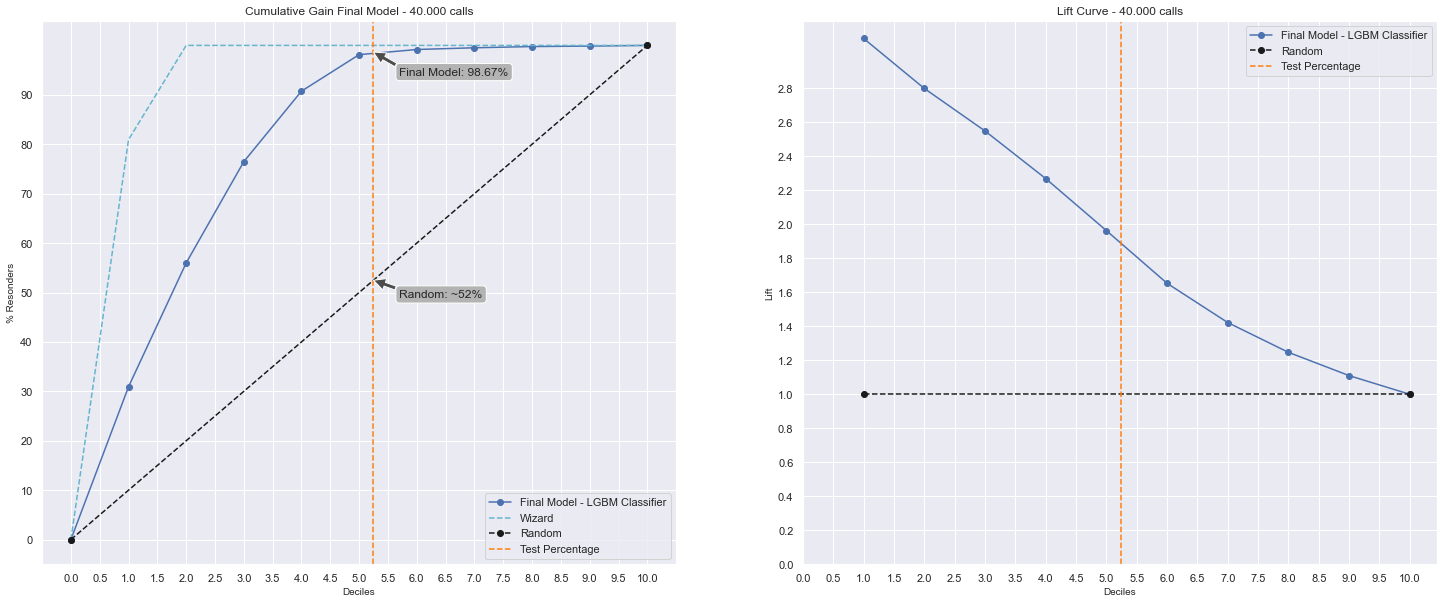

In [224]:
fig, ax = plt.subplots(figsize = (25, 10))

plt.subplot(1, 2, 1)
plot_cumulative_gain(y_val, yhat_lgbm_tuned[:,1])
plt.axvline(5.248, color ='#FF7F0E', ls = '--')
plt.title('Cumulative Gain Final Model - 40.000 calls')
plt.yticks(np.arange(0, 100, step = 10))
plt.xticks(np.arange(0, 10.5, step = 0.5))
plt.legend(['Final Model - LGBM Classifier', 'Wizard', 'Random', 'Test Percentage'])

arrowprops = dict(facecolor ='#4D4D4D')
plt.annotate('Final Model: 98.67%', xy = (5.248, 98.64),
                xytext =(5.7, 94), 
                arrowprops = arrowprops, bbox = bbox)

plt.annotate('Random: ~52%', xy = (5.248, 52.48),
                xytext =(5.7, 49), 
                arrowprops = arrowprops, bbox = bbox);



plt.subplot(1, 2, 2)
plot_lift(y_val, yhat_lgbm_tuned[:,1])
plt.axvline(5.248, color ='#FF7F0E', ls = '--')
plt.title('Lift Curve - 40.000 calls')
plt.yticks(np.arange(0, 3, step = 0.2))
plt.xticks(np.arange(0, 10.5, step = 0.5))
plt.legend(['Final Model - LGBM Classifier', 'Random', 'Test Percentage']);